# Symbolic Harmonic Change Detection in the Tonal Interval Space

The detection of chord boundaries (onset or beginning or chords in the musical surface) is typically addressed within Music Information Retrieval as harmonic change detection. Existing solutions are known to improve complex systems for automatic chord detection as a preprocessing segmentation stage. This project aims at improving the performance of harmonic change detection by adopting a tree-based representation for reducing the complex structure of symbolic music manifestations to an n-chord representation, targeting the basic underlying triadic structure of Western tonal harmony.

This is the code implemented to achieve the main objectives referred in the dissertation "Symbolic Harmonic Change Detection in the Tonal Interval Space" by José Macedo, with Gilberto Bernardes as Supervisor and Pedro Ramoneda as Co-Supervisor. 

In [1]:
import music21
import mido
from mido import MidiFile
import mirdata
import igraph as ig
import os
import plotly.express as px
import sys
import py_midicsv as pm
import glob
import csv
import json
import librosa
import pretty_midi
import libfmp.c1
import libfmp.b
import pickle
import mir_eval
#from TIVlib import TIV as tiv
import matplotlib.pyplot as plt
import pandas as pd
from unidecode import unidecode
from pymidi import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine, euclidean
from scipy.ndimage import gaussian_filter
#np.seterr(all='raise')

# TIS&TIV - Tonal Interval Space & Tonal Interval Vectors 

A truncated version of TIV library [1].

[1] - Ramires, A., Bernardes, G., Davies, M.E., & Serra, X. (2020). TIV.lib: an open-source library for the tonal description of musical audio. ArXiv, abs/2008.11529.

In [2]:
class TonalIntervalVector:
    weights_symbolic = [2, 11, 17, 16, 19, 7]
    weights_audio = [3, 8, 11.5, 15, 14.5, 7.5]

    def __init__(self, energy, vector):
        self.energy = energy
        self.vector = vector
    
    def abs_vector(self):
        return np.abs(self.vector)
    
    def phases_vector(self):
        return np.angle(self.vector)
    
    def get_vector(self):
        return np.array(self.vector)

    def diss(self): #Compute dissonance
        return 1 - (np.linalg.norm(self.vector) / np.sqrt(np.sum(np.dot(self.weights_symbolic, self.weights_symbolic))))

    def coeffs(self, coef): #Compute coefficient
        return self.abs_vector()[coef] / self.weights_symbolic[coef]

    def chromaticity(self): #Compute chromaticity
        return self.abs_vector()[0] / self.weights_symbolic[0]

    def dyads(self): #Compute dyadicity
        return self.abs_vector()[1] / self.weights_symbolic[1]

    def triads(self): #Compute triadicity (triads)
        return self.abs_vector()[2] / self.weights_symbolic[2]

    def d_q(self): #Refers a possible diminished quality
        return self.abs_vector()[3] / self.weights_symbolic[3]

    def diatonal(self): #Compute diatonicity
        return self.abs_vector()[4] / self.weights_symbolic[4]

    def tone(self): #Define wholetoneness
        return self.abs_vector()[5] / self.weights_symbolic[5]
    
    @classmethod
    def from_pcp(cls, pcp, symbolic=True):
        #      Get TIVs from pcp, as the original method
        #     :param pcp: 12xN vector containing N pcps
        #     :return: TIVCollection object
        #     """
        if pcp.shape[0] == 12:
            fft = np.fft.rfft(pcp, n=12)
            energy = fft[0]
            vector = fft[1:7]
            if symbolic:
                vector = ((vector / energy) * cls.weights_symbolic)
            else:
                vector = ((vector / energy) * cls.weights_audio)           
            return cls(energy, vector)
        else:
            return cls(complex(0), np.array([0, 0, 0, 0, 0, 0]).astype(complex))   

    def plot_TIV(self):
        titles = ["m2/M7", "TT", "M3/m6", "m3/M6", "P4/P5", "M2/m7"]
        TIVector = self.vector / self.weights_symbolic
        i = 1
        for tiv in TIVector:
            circle = plt.Circle((0, 0), 1, fill=False)
            plt.subplot(2, 3, i)
            plt.subplots_adjust(hspace=0.4)
            plt.gca().add_patch(circle)
            plt.title(titles[i - 1])
            plt.scatter(tiv.real, tiv.imag)
            plt.xlim((-1.5, 1.5))
            plt.ylim((-1.5, 1.5))
            plt.grid()
            i = i + 1
        plt.show()
        
    def hchange(self):
        tiv_array = self.vector
        results = []
        for i in range(len(tiv_array)):
            distance = TonalIntervalVector.euclidean(tiv_array[i + 1], tiv_array[i])
            results.append(distance)
        return results

    @classmethod
    def euclidean(cls, tiv1, tiv2):
        return np.linalg.norm(tiv1.vector - tiv2.vector)

    @classmethod
    def cosine(cls, tiv1, tiv2):
        a = np.concatenate((tiv1.vector.real, tiv1.vector.imag), axis=0)
        b = np.concatenate((tiv2.vector.real, tiv2.vector.imag), axis=0)
        if all_zero(a) or all_zero(b):
            distance_computed = euclidean(a, b)
        else:
            distance_computed = cosine(a, b)
        return distance_computed

In [3]:
#Taken from https://github.com/qsdfo/midi_to_numpy/blob/master/read_midi.py

#To read midi into piano rolls (the only part of this class that is adamant is read_file())
class Read_midi(object):
    def __init__(self, song_path, quantization):
        ## Metadata
        self.__song_path = song_path
        self.__quantization = quantization

        ## Pianoroll
        self.__T_pr = None

        ## Private misc
        self.__num_ticks = None
        self.__T_file = None

    @property
    def quantization(self):
        return self.__quantization

    @property
    def T_pr(self):
        return self.__T_pr

    @property
    def T_file(self):
        return self.__T_file

    def get_total_num_tick(self):
        # Midi length should be written in a meta message at the beginning of the file,
        # but in many cases, lazy motherfuckers didn't write it...

        # Read a midi file and return a dictionnary {track_name : pianoroll}
        mid = MidiFile(self.__song_path)

        # Parse track by track
        num_ticks = 0
        for i, track in enumerate(mid.tracks):
            tick_counter = 0
            for message in track:
                # Note on
                time = float(message.time)
                tick_counter += time
            num_ticks = max(num_ticks, tick_counter)
        self.__num_ticks = num_ticks

    def get_pitch_range(self):
        mid = MidiFile(self.__song_path)
        min_pitch = 200
        max_pitch = 0
        for i, track in enumerate(mid.tracks):
            for message in track:
                if message.type in ['note_on', 'note_off']:
                    pitch = message.note
                    if pitch > max_pitch:
                        max_pitch = pitch
                    if pitch < min_pitch:
                        min_pitch = pitch
        return min_pitch, max_pitch

    def get_time_file(self):
        # Get the time dimension for a pianoroll given a certain quantization
        mid = MidiFile(self.__song_path)
        # Tick per beat
        ticks_per_beat = mid.ticks_per_beat
        # Total number of ticks
        self.get_total_num_tick()
        # Dimensions of the pianoroll for each track
        self.__T_file = int((self.__num_ticks / ticks_per_beat) * self.__quantization)
        return self.__T_file

    def read_file(self):
        # Read the midi file and return a dictionnary {track_name : pianoroll}
        mid = MidiFile(self.__song_path)
        # Tick per beat
        ticks_per_beat = mid.ticks_per_beat

        # Get total time
        self.get_time_file()
        T_pr = self.__T_file
        # Pitch dimension
        N_pr = 128
        pianoroll = {}

        def add_note_to_pr(note_off, notes_on, pr):
            pitch_off, _, time_off = note_off
            # Note off : search for the note in the list of note on,
            # get the start and end time
            # write it in th pr
            match_list = [(ind, item) for (ind, item) in enumerate(notes_on) if item[0] == pitch_off]
            if len(match_list) == 0:
                print("Try to note off a note that has never been turned on")
                # Do nothing
                return

            # Add note to the pr
            pitch, velocity, time_on = match_list[0][1]
            pr[time_on:time_off, pitch] = velocity
            # Remove the note from notes_on
            ind_match = match_list[0][0]
            del notes_on[ind_match]
            return

        # Parse track by track
        counter_unnamed_track = 0
        for i, track in enumerate(mid.tracks):
            # Instanciate the pianoroll
            pr = np.zeros([T_pr, N_pr])
            time_counter = 0
            notes_on = []
            for message in track:

                ##########################################
                ##########################################
                ##########################################
                # TODO : keep track of tempo information
                # import re
                # if re.search("tempo", message.type):
                #     import pdb; pdb.set_trace()
                ##########################################
                ##########################################
                ##########################################


                # print message
                # Time. Must be incremented, whether it is a note on/off or not
                time = float(message.time)
                time_counter += time / ticks_per_beat * self.__quantization
                # Time in pr (mapping)
                time_pr = int(round(time_counter))
                # Note on
                if message.type == 'note_on':
                    # Get pitch
                    pitch = message.note
                    # Get velocity
                    velocity = message.velocity
                    if velocity > 0:
                        notes_on.append((pitch, velocity, time_pr))
                    elif velocity == 0:
                        add_note_to_pr((pitch, velocity, time_pr), notes_on, pr)
                # Note off
                elif message.type == 'note_off':
                    pitch = message.note
                    velocity = message.velocity
                    add_note_to_pr((pitch, velocity, time_pr), notes_on, pr)

            # We deal with discrete values ranged between 0 and 127
            #     -> convert to int
            pr = pr.astype(np.int16)
            if np.sum(np.sum(pr)) > 0:
                name = unidecode(track.name)
                name = name.rstrip('\x00')
                if name == u'':
                    name = 'unnamed' + str(counter_unnamed_track)
                    counter_unnamed_track += 1
                if name in pianoroll.keys():
                    # Take max of the to pianorolls
                    pianoroll[name] = np.maximum(pr, pianoroll[name])
                else:
                    pianoroll[name] = pr
        return pianoroll

# Auxiliary Functions 

By Pedro Ramoneda in "Harmonic Change Detection from Musical Audio"

In [4]:
def gaussian_blur(centroid_vector, sigma):
    centroid_vector = gaussian_filter(centroid_vector, sigma=sigma)
    return centroid_vector

def get_peaks_hcdf(hcdf_function, rate_centroids_second, symbolic=True):
    changes = [0]
    hcdf_changes = []
    last = 0
    for i in range(2, hcdf_function.shape[0] - 1):
        if hcdf_function[i - 1] < hcdf_function[i] and hcdf_function[i + 1] < hcdf_function[i]:
            hcdf_changes.append(hcdf_function[i])
            if not symbolic:
                changes.append(i / rate_centroids_second)
            else:
                changes.append(i)
            last = i
    return np.array(changes), np.array(hcdf_changes)

#4 - Distance Calculation (Euclidean and Cosine)
def distance_calc(centroid_point, distance):
    dist = []
    if distance == 'Euclidean':
        for j in range(1, centroid_point.shape[1] - 1):
            aux = 0
            for i in range(0, centroid_point.shape[0]):
                aux += ((centroid_point[i][j + 1] - centroid_point[i][j - 1]) ** 2)
            aux = np.math.sqrt(aux)
            dist.append(aux)
    
    if distance == 'Cosine':
        for j in range(1, centroid_point.shape[1] - 1):
            cosine_distance = cosine(centroid_point[:, j - 1], centroid_point[:, j + 1])
            dist.append(cosine_distance)
    dist.append(0)

    return np.array(dist)

In [5]:
#Now we will need to take information from TIV. So we will need some additional functions
def all_zero(vector):
    for element in vector:
        if element != 0:
            return False
    return True 

def real_imag(TIVector):
    aux = []
    for i in range(0, TIVector.shape[1]):
        real_vector = []
        imag_vector = []
        for j in range(0, TIVector.shape[0]):
            real_vector.append(TIVector[j][i].real)
            imag_vector.append(TIVector[j][i].imag)
        aux.append(real_vector)
        aux.append(imag_vector)
    return np.array(aux)

def tonalIntervalSpace(chroma, symbolic=True):
    centroid_vector = []
    for i in range(0, chroma.shape[1]):
        each_chroma = [chroma[j][i] for j in range(0, chroma.shape[0])]
        each_chroma = np.array(each_chroma)
        if all_zero(each_chroma):
            centroid = [0. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j, 0. + 0.j]
        else:
            tonal = TonalIntervalVector.from_pcp(each_chroma, symbolic)          #Calculate the TIV for each chroma
            #tonal.plot_TIV() #PLOT TIV for each chroma -> too expensive in terms of program's space
            centroid = tonal.get_vector()
        centroid_vector.append(centroid)
    return real_imag(np.array(centroid_vector))

In [6]:
def harmonic_change(chroma: list, window_size: int=2048, symbolic: bool=True, sigma: int=23, dist: str = 'euclidean'):
    chroma = np.array(chroma).transpose()
    centroid_vector = tonalIntervalSpace(chroma, symbolic=True)

    # Blur
    centroid_vector_blurred = gaussian_blur(centroid_vector, sigma)

    # Harmonic Distance Calculation - Euclidean or Cosine
    harmonic_function = distance_calc(centroid_vector_blurred, dist)

    changes, hcdf_changes = get_peaks_hcdf(harmonic_function, window_size, symbolic=True)

    return changes, hcdf_changes, harmonic_function

In [7]:
#JUST TO SEE WHAT CSV FILES CAN BRING UP TO THE TABLE...

#path_csv = "./BPS-FH_Dataset"
#dict1 = {1: 'beats.xlsx', 2: 'chords.xlsx', 3: 'dBeats.xlsx', 4: 'notes.csv', 5: 'phrases.xlsx'}
#files_csv = glob.glob(path_csv + '/*/' + dict1[4])

#def csv2midi(file):
#    midi = pm.csv_to_midi(file)                   
#    with open("Notes.mid", "wb") as midi_object:
#        midi_writer = pm.FileWriter(midi_object)
#        midi_writer.write(midi_object)
#    return midi_writer

#for file in files_csv:
#    m = csv2midi(file)

#RESPONSE: IT BRINGS NOTHING, BECAUSE THERE'S A PROBLEM WITH THE ENCODING MADE BY THE USED LIBRARY

In [8]:
np.set_printoptions(threshold=sys.maxsize)

# Piano Roll Representations

In order to represent musical scores for computational analysis, two-dimensional piano roll graphics (with columns being time steps and rows being pitches) are provided. It also gives a sense of pitch variation through all time steps.

In [9]:
path_score_BPS = './Midi_Files/BPS'
path_score_ABC = './Midi_Files/ABC'
file_list_BPS = glob.glob(path_score_BPS + '/*.mid')
file_list_ABC = glob.glob(path_score_ABC + '/*.mid')

C:\Users\HP\anaconda3\lib\site-packages\pretty_midi\pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 0 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\HP\anaconda3\lib\site-packages\libfmp\c1\c1s2_symbolic_rep.py:161: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize, dpi=dpi)
C:\Users\HP\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 0 missing from current font.
  font.set_text(s, 0, flags=flags)


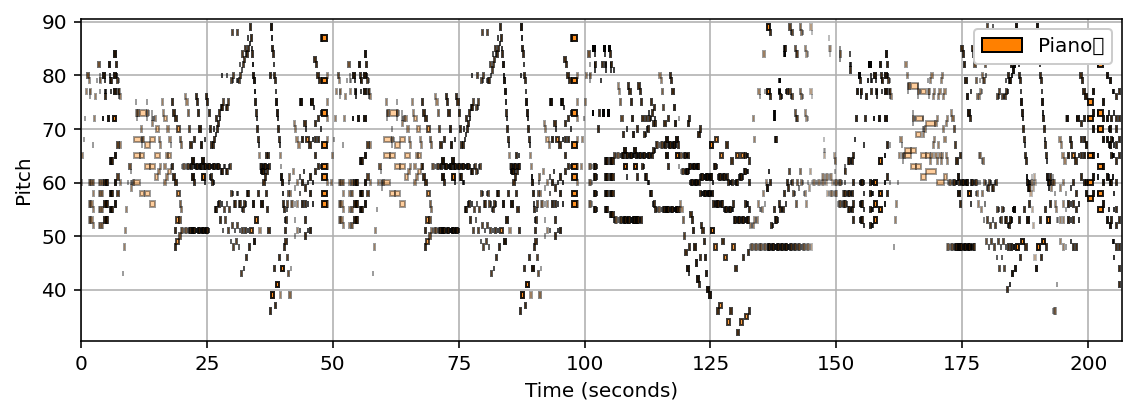

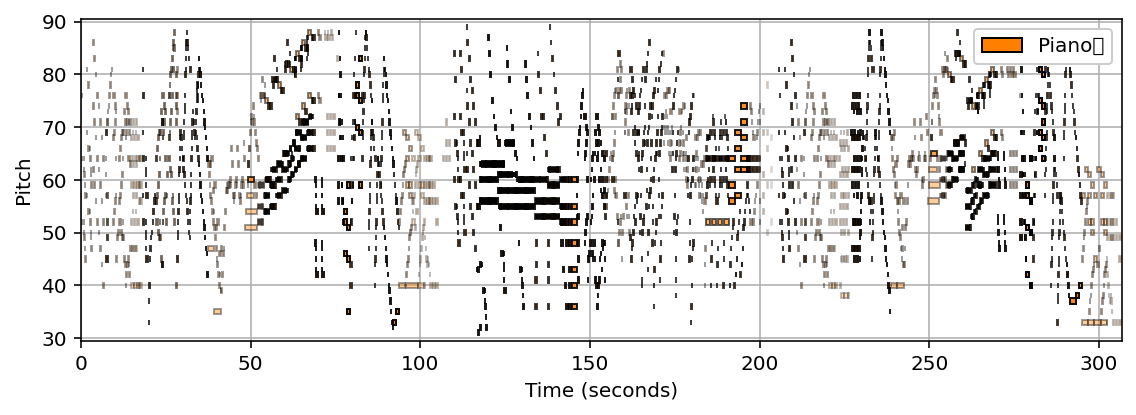

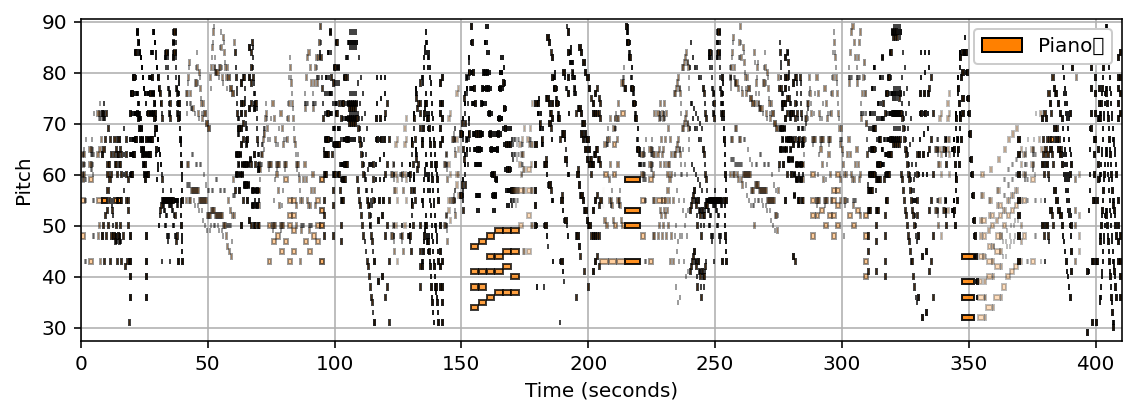

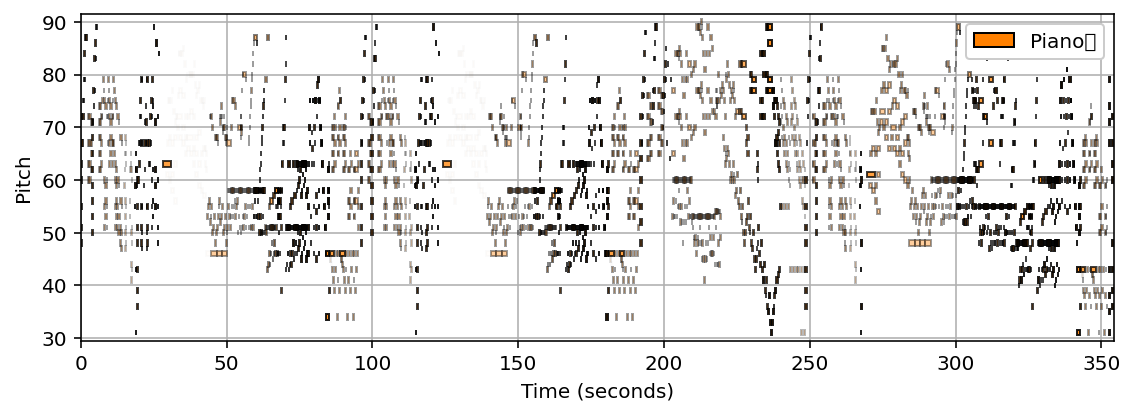

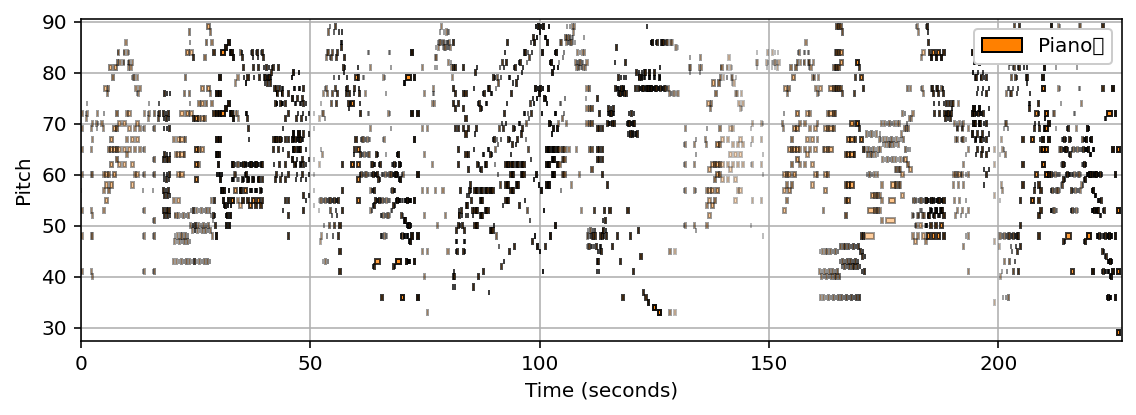

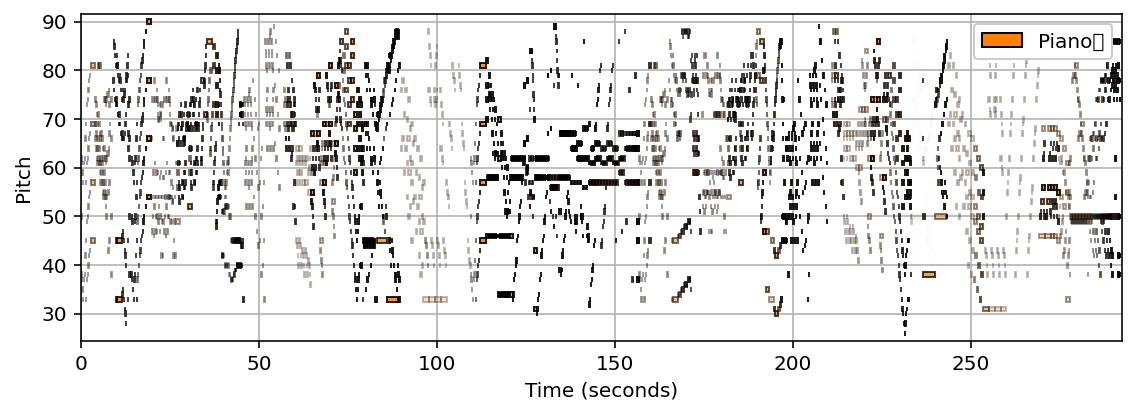

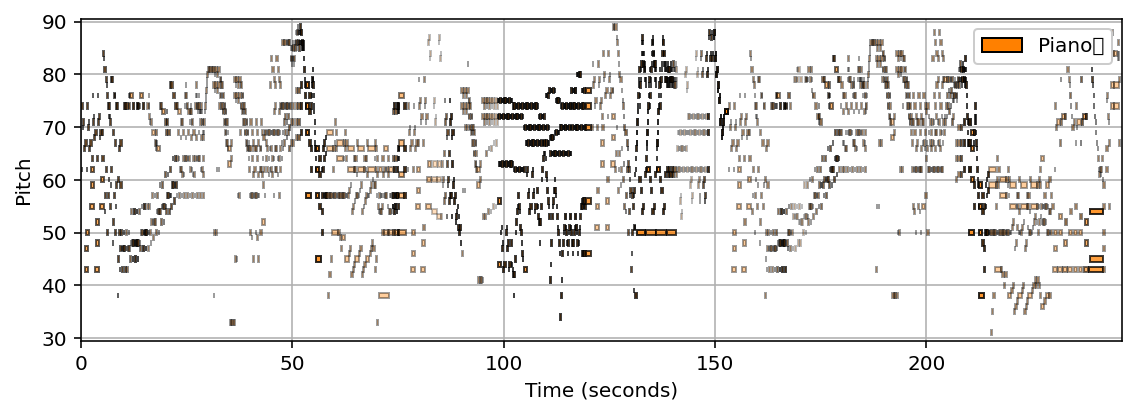

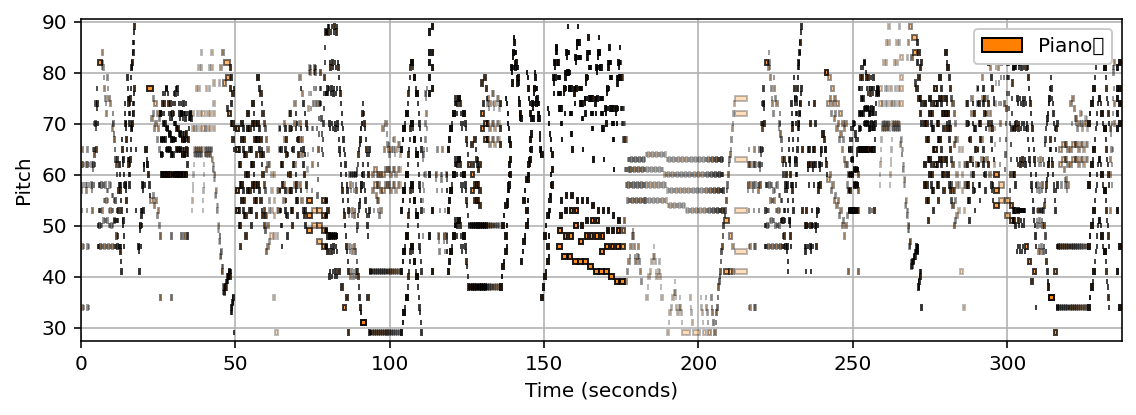

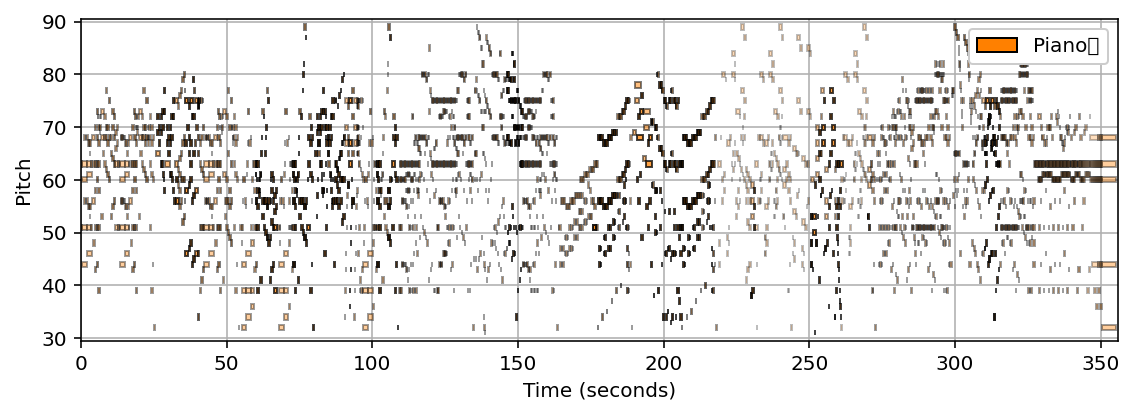

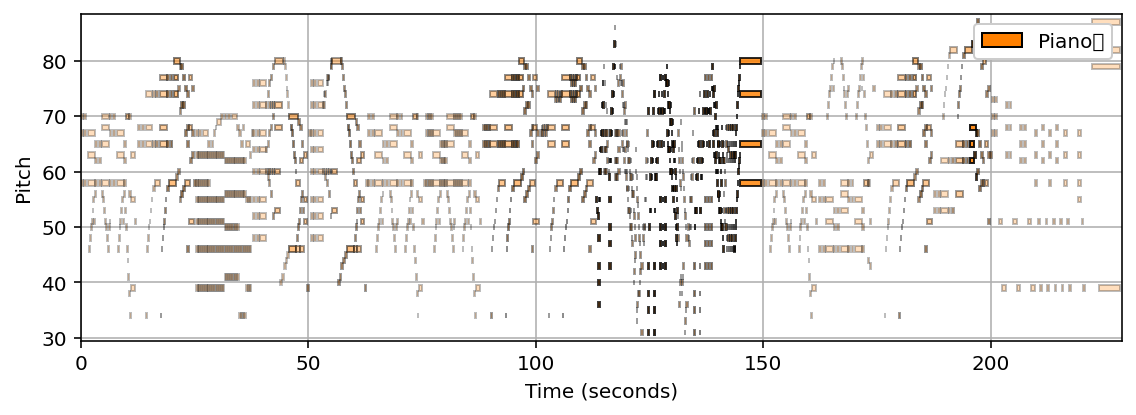

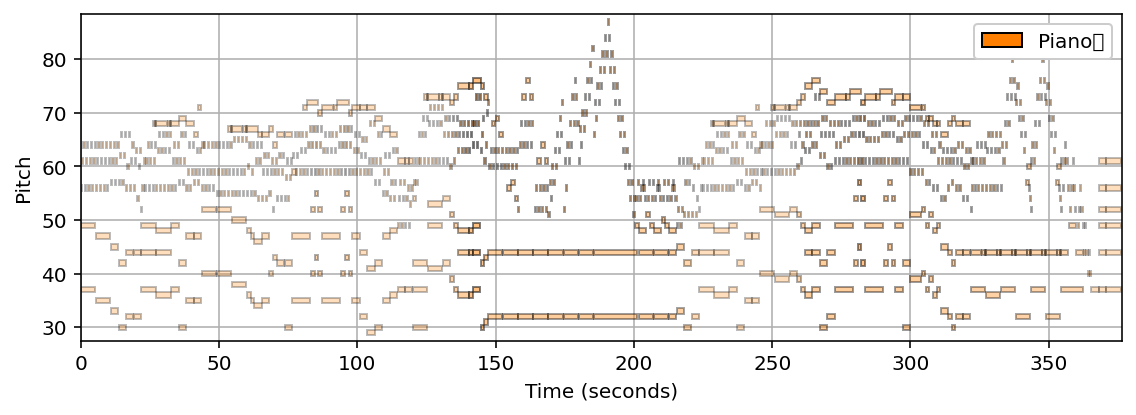

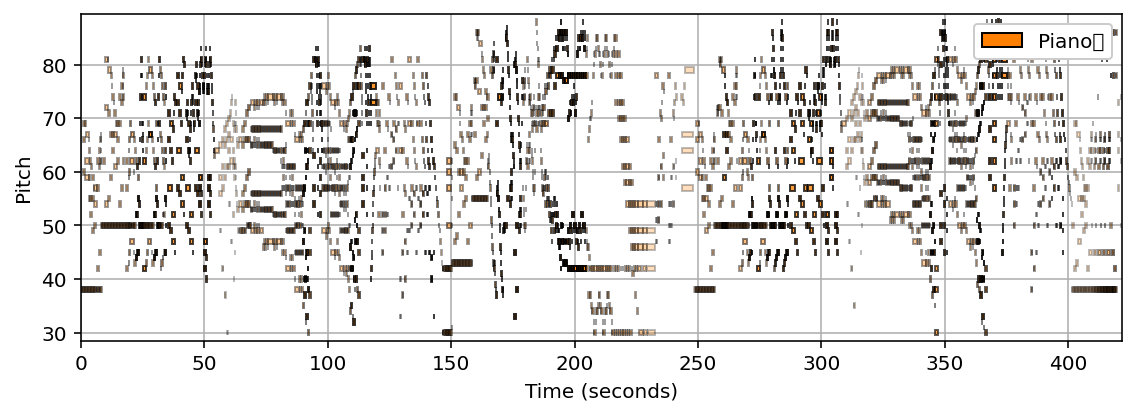

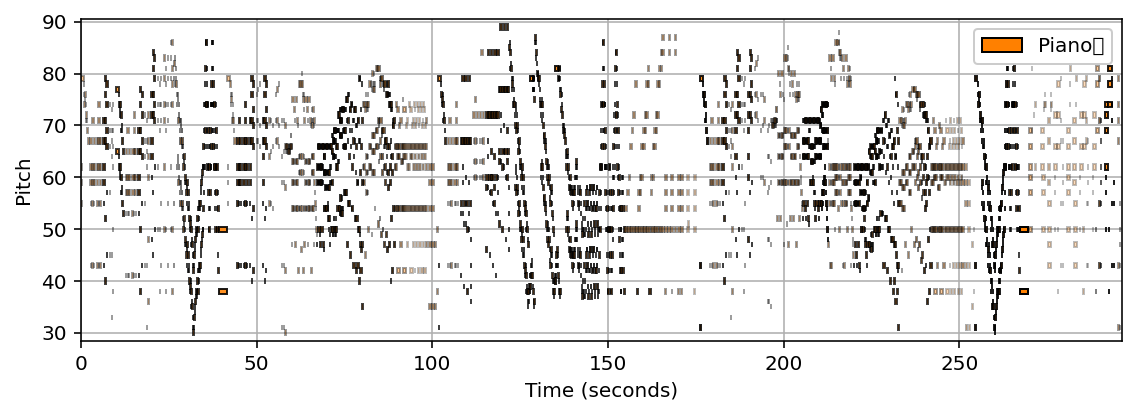

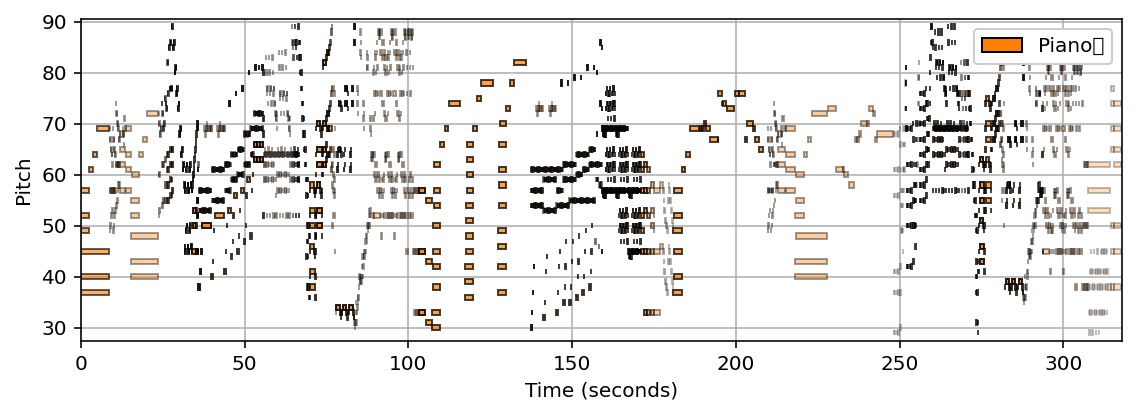

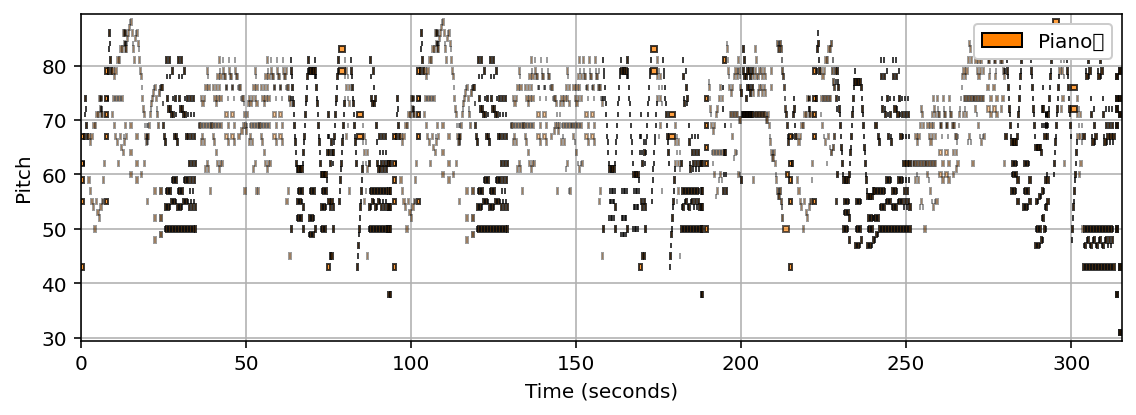

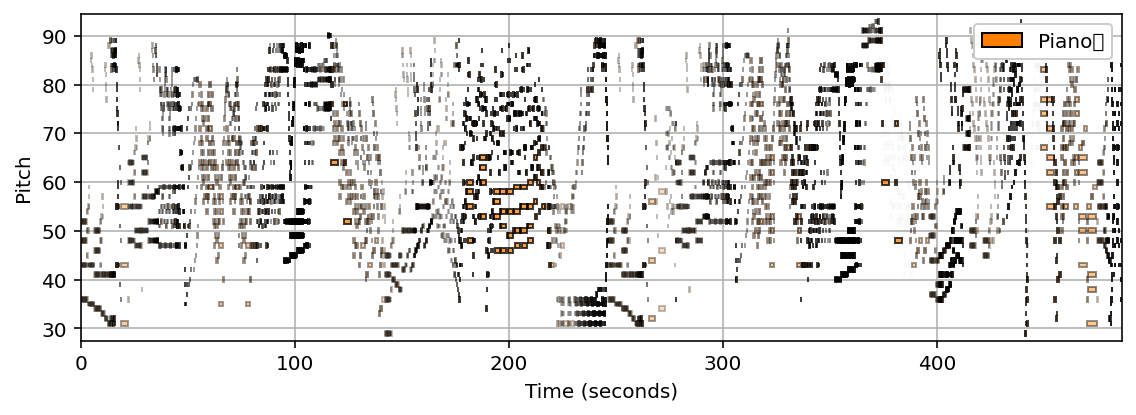

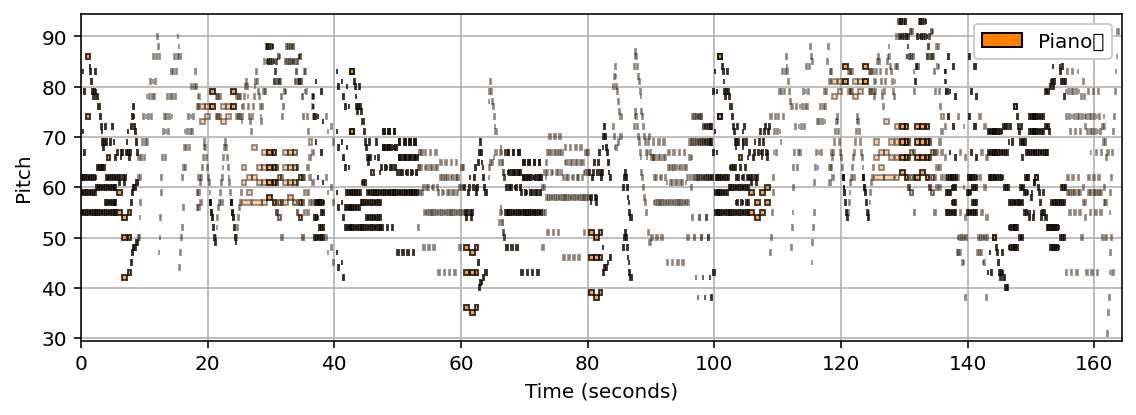

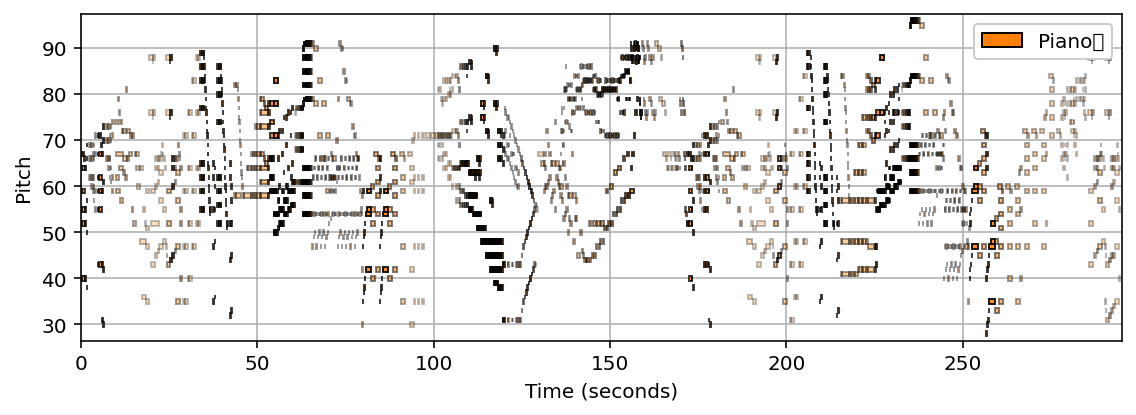

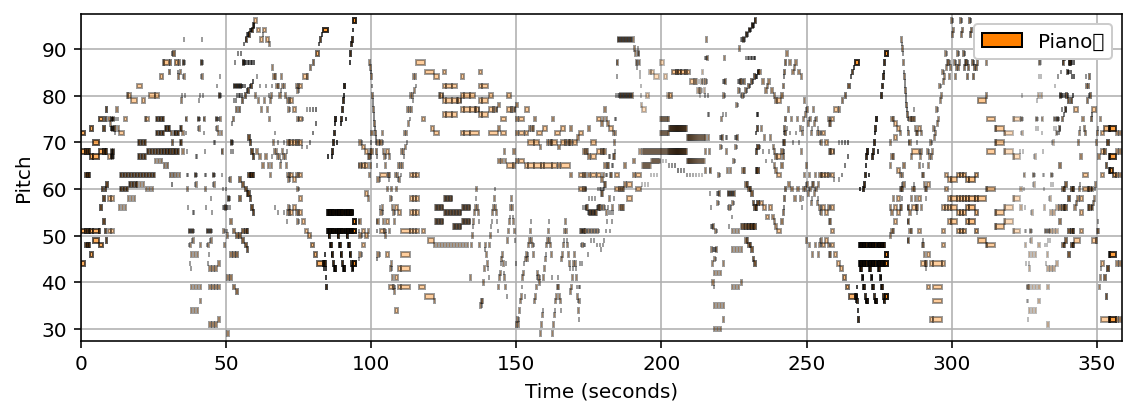

In [10]:
def midi_pianoRoll(file):
    midi_data = pretty_midi.PrettyMIDI(file)
    score = libfmp.c1.midi_to_list(midi_data)
    libfmp.c1.visualize_piano_roll(score, figsize=(8, 3), velocity_alpha=True);
    
####ANOTHER WAY TO PLOT PIANO ROLL GRAPHICS
#def midi_pianoRoll(file):
#    s = music21.converter.parse(file)
#    s.plot('pianoroll')


for file in file_list_BPS:
    midi_pianoRoll(file) ###IN CASE WE WANT TO PLOT PIANO ROLL GRAPHICS FOR BPS DATASET

#for file in file_list_ABC:
#    midi_pianoRoll(file) ###IN CASE WE WANT TO PLOT PIANO ROLL GRAPHICS FOR ABC DATASET

# Chroma Vectors

Chroma Vectors play an important role in music processing. Although mainly used for audio, it refers the cardinality of each pitch class in symbolic music (where the conotation "Harmonic Pitch Class Profile" is more suitable).

Given that music21 can't produce this kind of graphic, this was produced by libfmp library [2].

[2] - Meinard Müller and Frank Zalkow. libfmp: A Python Package for Fundamentals of Music Processing. Journal of Open Source Software (JOSS), 6(63), 2021.

C:\Users\HP\anaconda3\lib\site-packages\libfmp\b\b_plot.py:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)


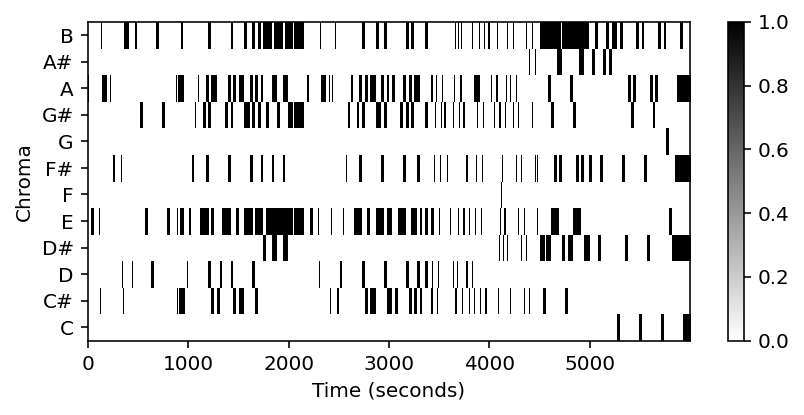

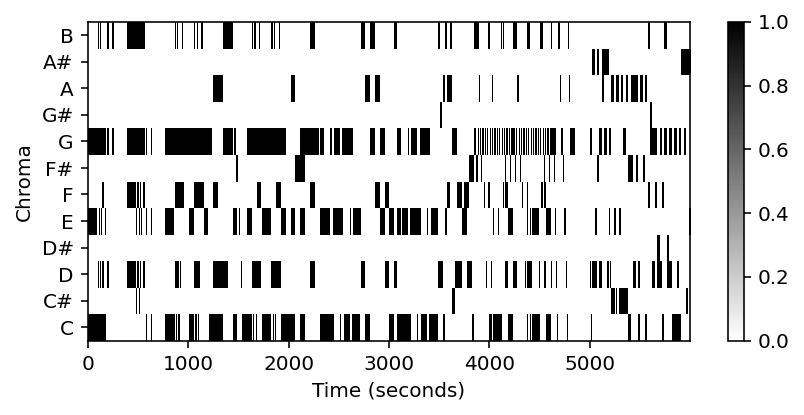

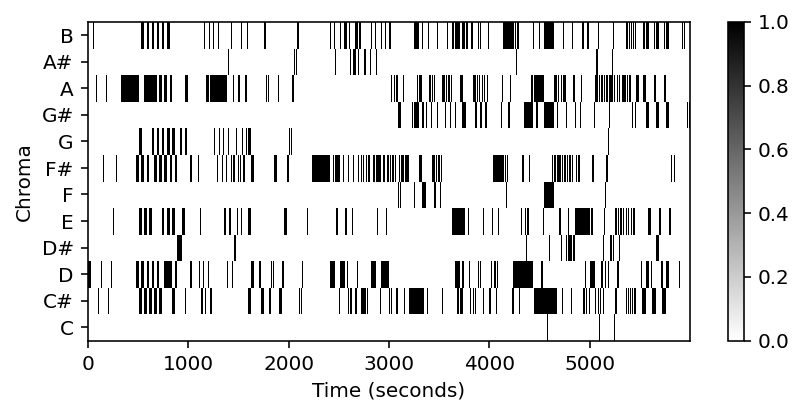

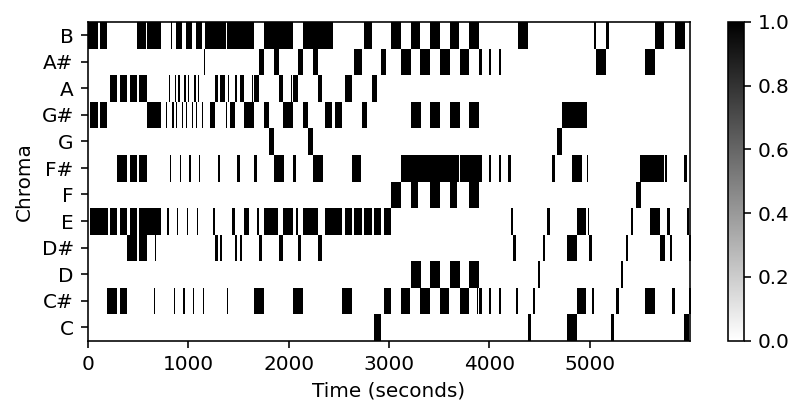

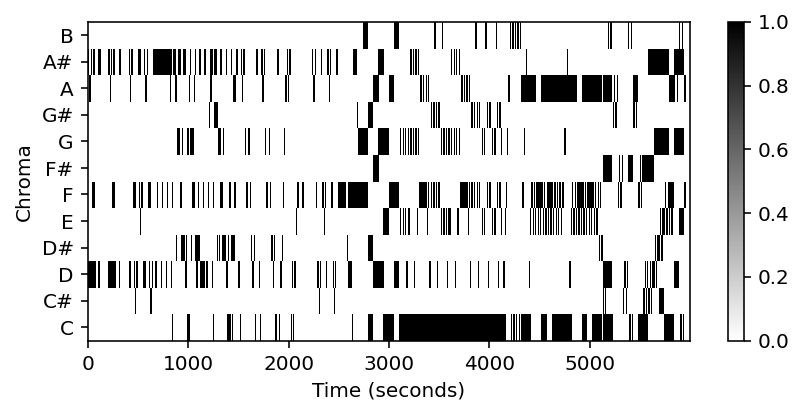

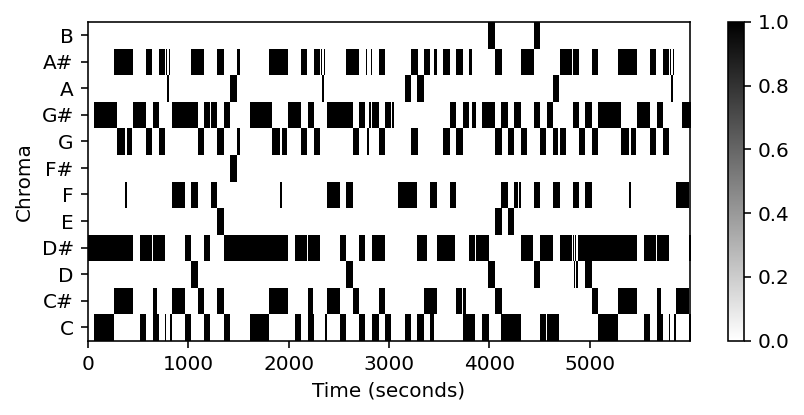

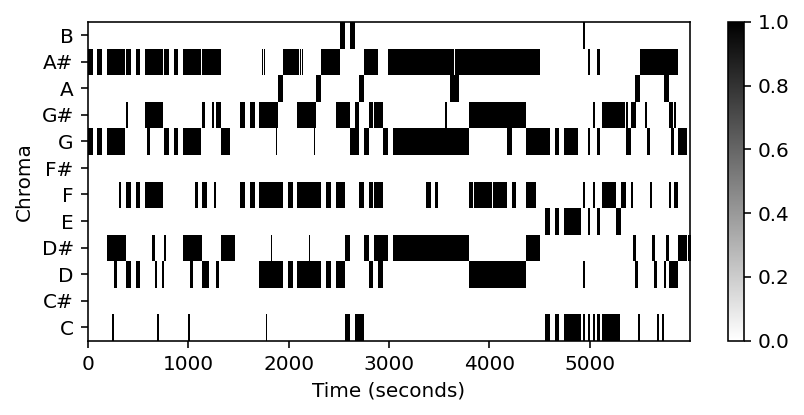

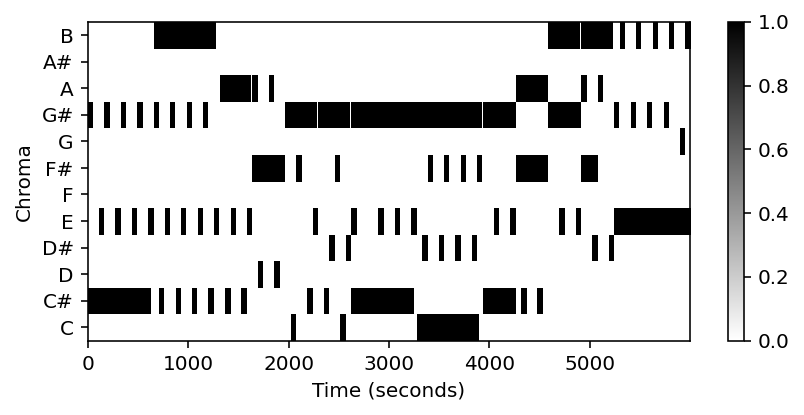

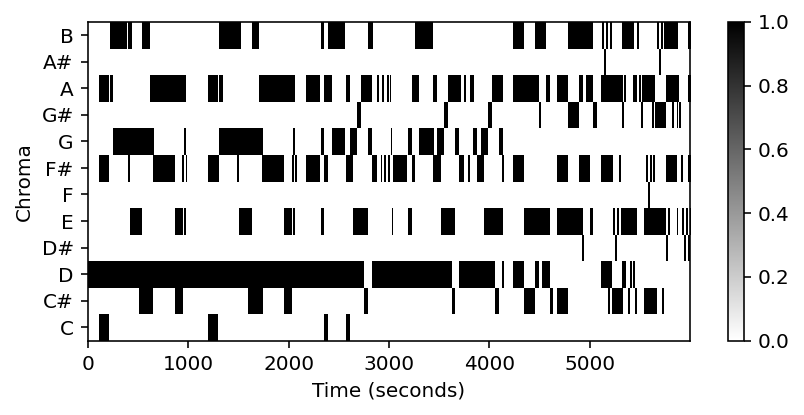

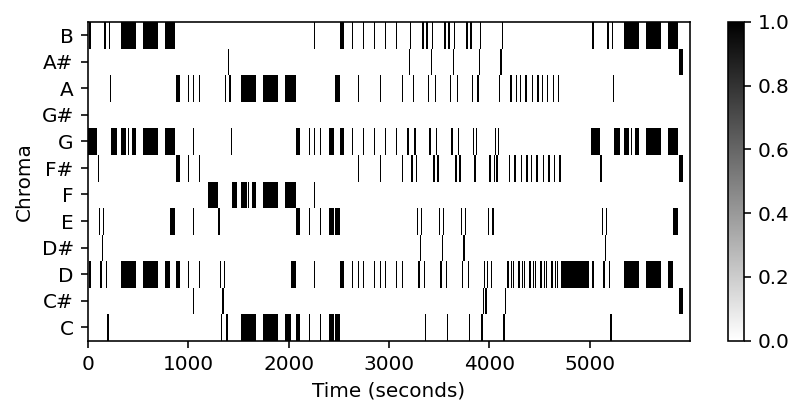

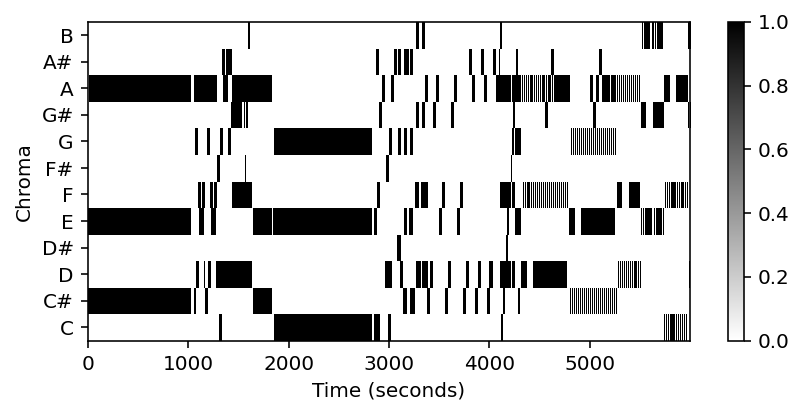

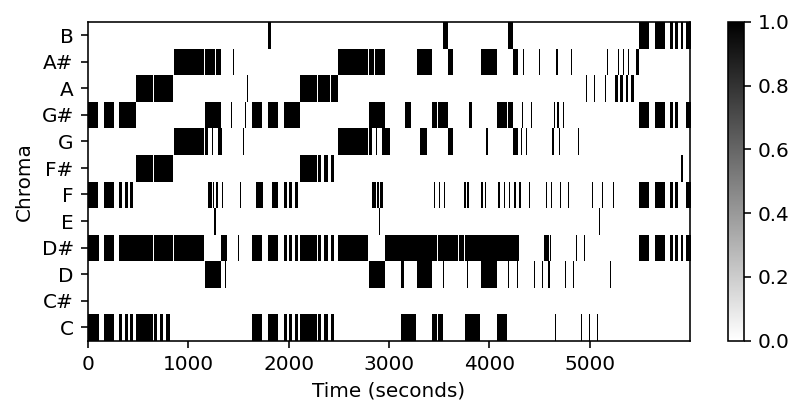

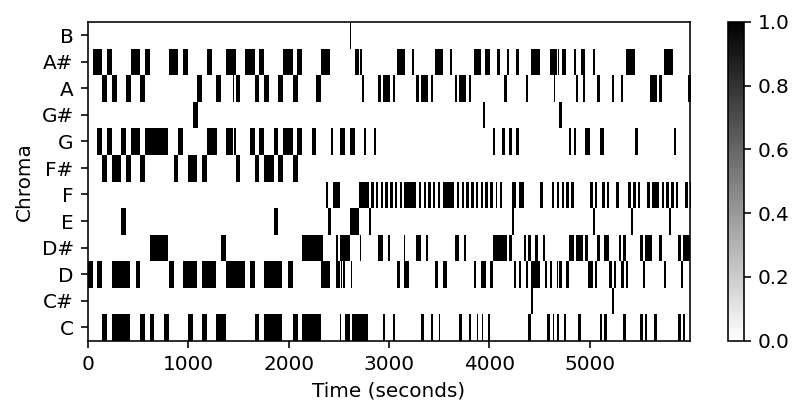

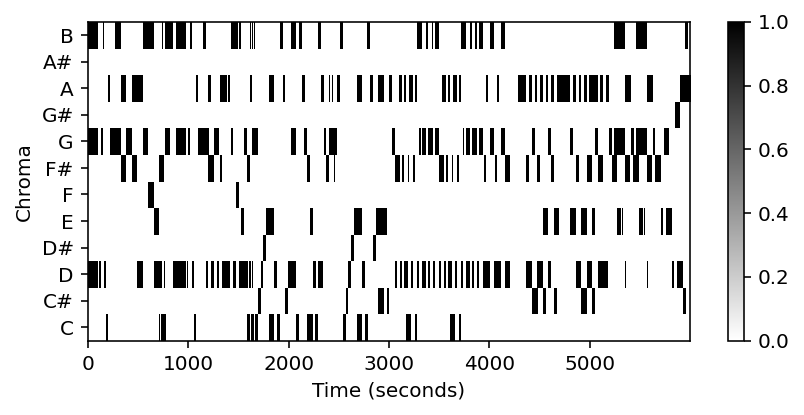

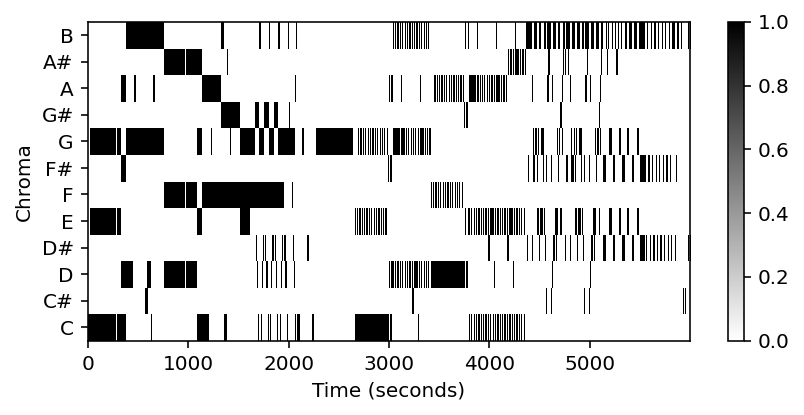

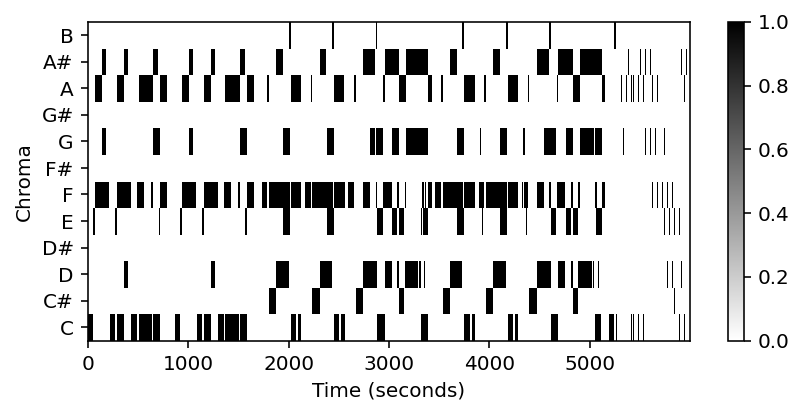

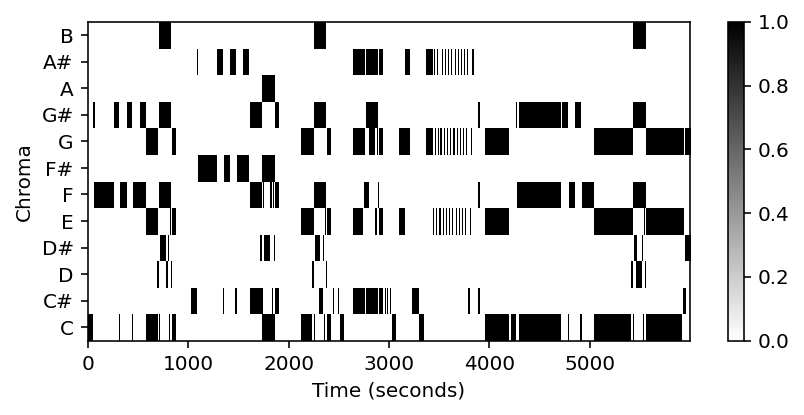

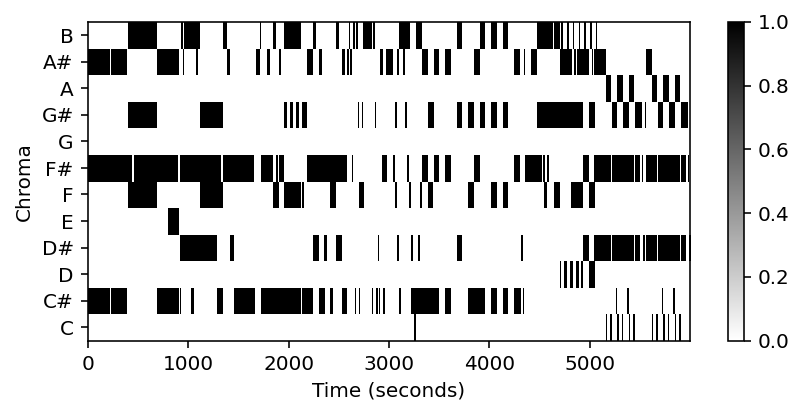

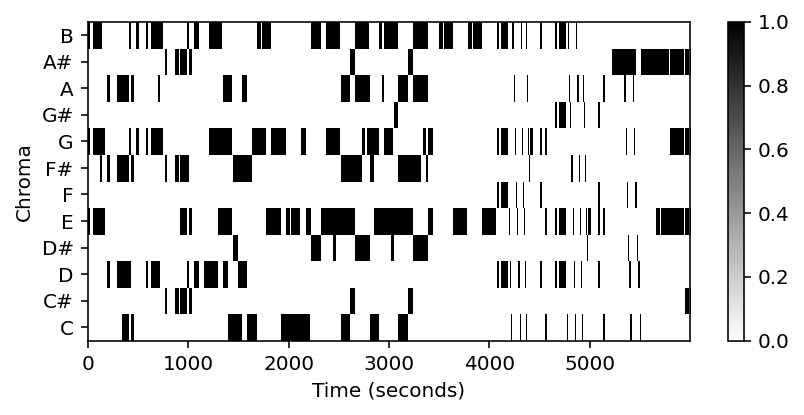

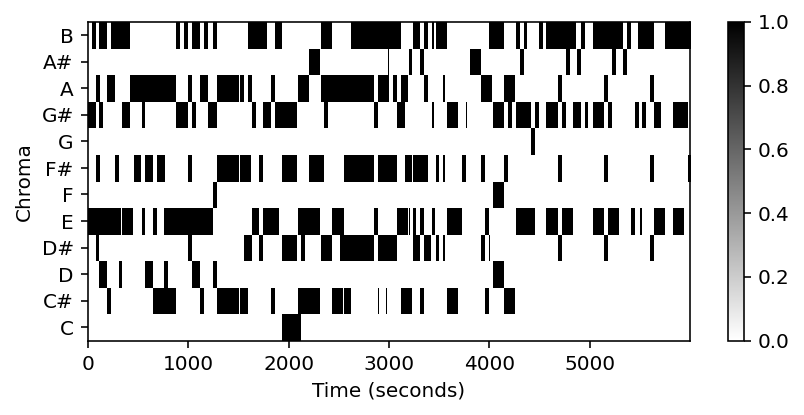

In [11]:
def chromagram(midi_file):
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    score = libfmp.c1.midi_to_list(midi_data)
    chromagram = libfmp.b.b_sonification.list_to_chromagram(score, 6000, 120)
    #chroma = libfmp.b.b_plot.plot_chromagram(chromagram)

    return chromagram

for file in file_list_BPS:
    chroma_bps = chromagram(file) 
    c_b = libfmp.b.b_plot.plot_chromagram(chroma_bps) ###JUST IN CASE WE WANT TO PLOT CHROMAGRAMS BPS DATASET
    
#for file in file_list_ABC:
#    chroma_abc = chromagram(file) 
#    c_a = libfmp.b.b_plot.plot_chromagram(chroma_abc) ###JUST IN CASE WE WANT TO PLOT CHROMAGRAMS ABC DATASET

For the next step, it will be necessary to transform the file into a suitable 12-element vector, according to TIV dimensions.

In [12]:
def midi2chroma(m_vector):
    vector = np.zeros((m_vector.shape[0], 12))
    for i, frame in enumerate(m_vector):
        for j, element in enumerate(frame):
            vector[i][j % 12] += element
    return vector

#for file in file_list_BPS:
#    midi_vector = Read_midi(file,28).read_file()
   # for times, key in midi_vector.items():
   #     print(key.shape)
#    vec = (list(midi_vector.values()))[0]
#    chroma_vector = midi2chroma(vec)
    #print(chroma_vector.shape)
    
#for file in file_list_ABC:
#    midi_vector = Read_midi(file,23).read_file()
#    for times, key in midi_vector.items():
#        print(key.shape)                        #HAVE A LOT "Try to note off a note that has never been turned on"
#    vec = (list(midi_vector.values()))[0]
#    chroma_vector = midi2chroma(vec)
#    print(chroma_vector.shape)

#chroma = np.array(chroma_vector).transpose()
#print(chroma.shape[1])

In [21]:
def time_pitch(file):
    midi_data = pretty_midi.PrettyMIDI(file)
    score = libfmp.c1.midi_to_list(midi_data)
    df = pd.DataFrame(score, columns=['Start', 'Duration', 'Pitch', 'Velocity', 'Instrument'])
    df.drop_duplicates(subset ="Start", keep = "first", inplace = True)
    dct = dict(zip(df.Start, df.Pitch))
    return dct
    #return df.iloc[:,0].values
    
for file in file_list_BPS:
    bps = time_pitch(file)
    keys_list_bps = list(bps)
    print(keys_list_bps)
    
#for file in file_list_ABC:
#    abc = time_pitch(file)
#    keys_list_abc = list(abc)
#    print(keys_list_abc)

[0.0, 0.258621, 0.517242, 0.775863, 1.034484, 1.293105, 1.6810365, 1.72414, 1.7672435, 1.8103470000000002, 2.327589, 2.58621, 2.844831, 3.103452, 3.362073, 3.7500045, 3.793108, 3.8362115, 3.879315, 4.3965570000000005, 4.46121225, 4.7844885, 4.827592, 4.8706955, 4.913799, 5.4310410000000005, 5.49569625, 5.8189725, 5.862076, 5.9051795, 5.948283, 6.5307190437500005, 6.5980682625, 6.6648786875, 6.465525, 6.982767, 7.1120775, 7.241388000000001, 7.3706985000000005, 7.500009, 7.54257370625, 7.585677206250001, 7.6293195, 7.75863, 10.9913925, 11.034496, 11.0775995, 11.120703, 11.379324, 10.603461000000001, 12.0258765, 12.06898, 12.1120835, 12.155187, 12.413808, 11.637945, 13.0603605, 13.103464, 13.1465675, 13.189671, 13.448292, 12.672429000000001, 14.0948445, 14.137948, 14.1810515, 14.224155, 14.482776000000001, 13.706913, 14.741397000000001, 15.000018, 15.51726, 15.775881, 16.034502, 16.293123, 16.551744, 17.068986, 17.586228000000002, 17.844849, 18.10347, 18.362091, 18.620712, 19.137954, 19.6

[0.0, 0.2272725, 0.90909, 0.965908125, 1.02272625, 1.079544375, 1.1363625, 1.81818, 2.0454525, 2.72727, 2.784088125, 2.84090625, 2.897724375, 2.9545425, 3.63636, 3.8636325, 4.3181775, 4.7727225, 5.2272675, 5.6818125, 6.1363575, 6.5909025, 7.27272, 7.3484775, 7.424235, 7.4999925, 7.727265, 7.9545375, 8.18181, 8.4090825, 8.636355, 8.8636275, 9.0909, 9.545445, 9.3181725, 9.7727175, 9.99999, 10.2272625, 11.363625, 11.5908975, 11.81817, 12.0454425, 12.272715, 12.4999875, 12.72726, 12.954532500000001, 13.181805, 13.4090775, 13.63635, 13.8636225, 14.090895, 14.3181675, 14.54544, 14.7727125, 14.999985, 15.2272575, 15.45453, 15.6818025, 15.909075, 16.1363475, 16.36362, 16.5908925, 17.0454375, 17.4999825, 18.1818, 18.4090725, 19.09089, 19.147708125, 19.20452625, 19.261344375, 19.3181625, 22.272705, 22.4999775, 22.72725, 22.9545225, 23.181795, 23.4090675, 23.63634, 23.8636125, 24.090885, 24.3181575, 24.54543, 24.7727025, 25.909065000000002, 26.1363375, 26.36361, 26.5908825, 26.818155, 27.0454275,

[0.0, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.4000000000000001, 1.6, 2.0, 3.2, 4.0, 4.1000000000000005, 4.2, 4.300000000000001, 4.4, 4.6000000000000005, 4.800000000000001, 5.2, 6.4, 7.2, 7.300000000000001, 7.4, 7.500000000000001, 7.6000000000000005, 7.800000000000001, 8.0, 8.4, 8.8, 8.9, 9.0, 9.100000000000001, 9.200000000000001, 9.4, 9.600000000000001, 10.0, 10.8, 10.4, 11.200000000000001, 11.600000000000001, 12.0, 13.200000000000001, 13.600000000000001, 14.000000000000002, 14.4, 14.8, 15.200000000000001, 15.600000000000001, 16.0, 16.8, 17.6, 18.400000000000002, 19.200000000000003, 19.3, 19.400000000000002, 19.5, 19.6, 19.700000000000003, 19.8, 19.900000000000002, 20.0, 20.1, 20.200000000000003, 20.3, 20.400000000000002, 20.5, 20.6, 20.700000000000003, 20.8, 20.900000000000002, 21.0, 21.1, 21.200000000000003, 21.3, 21.400000000000002, 21.5, 21.6, 21.700000000000003, 21.8, 21.900000000000002, 22.0, 22.1, 22.200000000000003, 22.3, 22.400000000000002, 22.5, 22.6, 22.700000000000003, 22

[0.0, 0.972972, 1.945944, 2.918916, 3.7297259999999994, 3.891888, 4.054049999999999, 4.216212, 4.378374, 4.5405359999999995, 4.702698, 4.864859999999999, 5.027022, 5.189183999999999, 5.3513459999999995, 5.513508, 5.675669999999999, 5.837832, 5.999993999999999, 6.1621559999999995, 6.324317999999999, 6.486479999999999, 6.648642, 6.810803999999999, 6.9729659999999996, 7.135127999999999, 7.297289999999999, 7.459451999999999, 7.621613999999999, 7.783776, 7.945937999999999, 8.108099999999999, 8.270261999999999, 8.432424, 8.594586, 8.756748, 8.918909999999999, 9.081071999999999, 9.243234, 9.405396, 9.567557999999998, 9.729719999999999, 9.891881999999999, 10.054044, 10.216206, 10.378367999999998, 10.540529999999999, 10.702691999999999, 10.864854, 11.027016, 11.189177999999998, 11.351339999999999, 11.513501999999999, 11.675664, 12.162149999999999, 13.135121999999999, 13.621607999999998, 14.594579999999999, 15.567552, 17.027009999999997, 17.189172, 17.351333999999998, 17.513496, 17.675658, 17.83

[0.0, 0.5329957500000001, 0.6091380000000001, 0.8375647500000001, 0.9137070000000002, 1.1421337500000002, 1.2182760000000001, 1.4467027500000003, 1.5228450000000002, 1.8274140000000003, 2.4365520000000003, 2.741121, 3.3502590000000003, 3.6548280000000006, 4.187823750000001, 4.263966000000001, 4.4923927500000005, 4.568535000000001, 4.79696175, 4.8731040000000005, 5.10153075, 5.177673, 5.482242, 6.091380000000001, 6.395949000000001, 7.0050870000000005, 7.309656000000001, 7.374376912500001, 7.439097825000001, 7.766509500000001, 7.918794000000001, 8.223363, 8.832501, 9.137070000000001, 9.201790912500002, 9.266511825, 9.3312327375, 9.5939235, 9.746208000000001, 10.050777000000002, 10.659915000000002, 10.964484, 11.029204912500001, 11.093925825000001, 11.158646737500002, 11.421337500000002, 11.573622000000002, 12.182760000000002, 12.487329, 13.096467000000002, 13.401036000000001, 14.010174000000001, 14.923881000000002, 15.025404000000002, 15.126927000000002, 15.228450000000002, 15.3299730000

[0.0, 0.280374, 1.121496, 1.2149539999999999, 1.308412, 1.40187, 2.242992, 2.5233659999999998, 3.3644879999999997, 3.4579459999999997, 3.551404, 3.644862, 4.485984, 4.766357999999999, 4.9766385, 5.0467319999999996, 5.60748, 5.887854, 6.168228, 6.728975999999999, 7.289724, 7.850472, 7.990659, 8.130846, 8.41122, 9.252341999999999, 9.3224355, 9.392529, 9.4626225, 9.532715999999999, 10.093463999999999, 10.233651, 10.373838, 10.419398775, 10.466127775, 10.514025, 10.654212, 11.1448665, 11.21496, 11.4252405, 11.495334, 11.775708, 12.2663625, 12.336456, 12.5467365, 12.61683, 13.457951999999999, 13.738325999999999, 14.579448, 14.672906, 14.766364, 14.859822, 15.700944, 15.981318, 16.82244, 16.915898, 17.009356, 17.102814, 17.943936, 18.037394, 18.130852, 18.22431, 18.504683999999997, 18.598142, 18.691599999999998, 18.785058, 19.065431999999998, 19.15889, 19.252347999999998, 19.345806, 20.186927999999998, 20.467302, 21.02805, 21.588798, 22.42992, 22.710293999999998, 22.990668, 23.551416, 23.691

[0.0, 0.21126799999999998, 0.42253599999999997, 0.633804, 0.8450719999999999, 1.05634, 1.267608, 1.4788759999999999, 1.6901439999999999, 1.9014119999999999, 2.11268, 2.323948, 2.535216, 2.7464839999999997, 4.014089, 4.225357, 4.436625, 4.647893, 4.859161, 5.070429000000001, 5.281697, 5.492965, 5.704233, 5.915501, 6.126769, 6.338037, 6.549305, 6.760573, 6.9718409999999995, 7.183109, 7.394377, 7.816913, 8.028181, 8.239449, 8.450717000000001, 9.084521, 9.190155, 9.295789, 9.401423000000001, 9.507057, 9.612691, 9.718325, 9.823959, 9.929593, 10.035226999999999, 10.140861000000001, 10.246495, 10.352129, 10.457763, 10.563397, 10.669031, 10.774664999999999, 10.880299, 10.985933, 11.091567000000001, 11.197201, 11.302835, 11.408469, 11.514103, 11.619737, 11.725370999999999, 11.831005000000001, 11.936639, 12.042273, 12.147907, 12.253541, 12.359175, 12.464809, 12.570443, 12.676077, 12.781711, 12.887345, 12.992979, 13.098613, 13.204247, 13.309881, 13.521149, 14.260587, 14.471855, 14.683123, 14.8943

[0.0, 2.75, 3.0, 3.75, 4.0, 6.0, 8.0, 10.75, 11.0, 11.75, 12.0, 14.0, 16.0, 18.75, 19.0, 19.75, 20.0, 22.0, 22.75, 23.0, 23.75, 24.0, 26.0, 27.0, 28.0, 29.0, 30.25, 30.375, 30.5, 30.625, 30.75, 30.875, 31.0, 31.125, 31.25, 31.375, 31.5, 31.5625, 31.625, 31.6875, 31.75, 31.8125, 31.875, 31.9375, 32.0, 33.0, 34.75, 35.0, 35.75, 36.0, 37.0, 37.75, 38.0, 38.75, 39.0, 39.75, 40.0, 41.0, 42.75, 43.0, 43.75, 44.0, 45.0, 45.75, 46.0, 46.75, 47.0, 47.75, 48.0, 49.0, 50.75, 51.0, 51.75, 52.0, 53.0, 55.0, 55.75, 56.0, 57.0, 59.0, 59.75, 60.0, 61.0, 63.0, 64.0, 65.25, 65.375, 65.5, 65.625, 65.75, 65.875, 66.0, 66.5, 67.0, 67.5, 68.0, 72.0, 73.25, 73.375, 73.5, 73.58333333333333, 73.66666666666667, 73.75, 73.83333333333333, 73.91666666666667, 74.0, 74.5, 75.0, 75.5, 76.0, 76.5, 77.0, 77.08333333333333, 77.16666666666667, 77.25, 77.33333333333333, 77.41666666666667, 77.5, 77.57083333333333, 77.64166666666667, 77.7125, 77.7875, 77.85833333333333, 77.92916666666666, 78.0, 78.0625, 78.125, 78.1875, 78.

[0.0, 0.81081, 1.62162, 2.43243, 3.24324, 4.05405, 4.86486, 5.4729675, 5.574318750000001, 5.67567, 6.48648, 6.587831250000001, 6.6891825, 6.790533750000001, 6.891885, 6.993236250000001, 7.0945875, 7.195938750000001, 7.29729, 8.1081, 8.20945125, 8.310802500000001, 8.41215375, 8.513505, 8.61485625, 8.716207500000001, 8.817558750000002, 8.91891, 10.135125, 10.337827500000001, 10.54053, 10.743232500000001, 10.945935, 11.148637500000001, 9.932422500000001, 11.554042500000001, 11.655393750000002, 11.604718125000002, 11.756745, 11.959447500000001, 12.16215, 12.364852500000001, 12.567555, 11.706069375, 12.770257500000001, 13.581067500000001, 12.97296, 13.682418750000002, 13.78377, 13.986472500000001, 14.189175, 14.391877500000001, 14.59458, 15.810795, 16.8243075, 16.2162, 16.92565875, 17.02701, 17.2297125, 17.432415000000002, 17.635117500000003, 17.83782, 19.45944, 20.27025, 21.08106, 21.89187, 22.70268, 23.51349, 24.3243, 25.13511, 25.94592, 26.351325000000003, 26.75673, 27.364837500000004, 2

[0.1530615, 0.306123, 0.45918449999999994, 0.612246, 0.7653074999999999, 0.9183689999999999, 1.3775534999999999, 1.5306149999999998, 1.6836764999999998, 1.8367379999999998, 1.9897994999999997, 2.142861, 2.6020454999999996, 2.7551069999999998, 2.9081684999999995, 3.0612299999999997, 3.2142915, 3.3673529999999996, 3.8265374999999997, 3.9795989999999994, 4.132660499999999, 4.285722, 4.4387834999999995, 4.591844999999999, 5.051029499999999, 5.204090999999999, 5.3571525, 5.5102139999999995, 5.9693985, 6.122459999999999, 6.275521499999999, 6.428583, 6.5816444999999995, 6.734705999999999, 6.811236749999999, 6.887767499999999, 7.193890499999999, 7.346951999999999, 7.500013499999999, 7.806136499999999, 7.959197999999999, 8.112259499999999, 8.4183825, 8.571444, 8.7245055, 9.030628499999999, 9.183689999999999, 10.102058999999999, 10.408181999999998, 10.714305, 11.020427999999999, 11.326550999999998, 11.403081749999998, 11.479612499999998, 11.556143249999998, 11.632673999999998, 12.244919999999999

[0.0, 0.10563375, 0.2112675, 0.31690125, 0.422535, 0.84507, 1.69014, 1.79577375, 1.9014075, 2.00704125, 2.112675, 2.53521, 3.38028, 3.48591375, 3.5915475, 3.69718125, 3.802815, 3.90844875, 4.0140825, 4.11971625, 4.22535, 4.33098375, 4.4366175, 4.54225125, 4.647885, 4.75351875, 4.8591524999999995, 4.9647862499999995, 5.07042, 5.17605375, 5.2816875, 5.38732125, 5.492955, 6.76056, 6.86619375, 6.9718275, 7.07746125, 7.183095, 7.3943625, 7.60563, 7.8168975, 8.028165, 8.2394325, 8.4507, 8.6619675, 8.873235, 9.29577, 10.14084, 10.24647375, 10.3521075, 10.45774125, 10.563375, 10.7746425, 10.98591, 11.1971775, 11.408445, 11.6197125, 11.83098, 12.0422475, 12.253515, 12.4647825, 12.57041625, 12.67605, 12.78168375, 12.8873175, 12.992951249999999, 13.098585, 13.3098525, 13.415486249999999, 13.52112, 13.62675375, 13.7323875, 13.83802125, 13.943655, 14.1549225, 14.26055625, 14.36619, 14.47182375, 14.5774575, 14.68309125, 14.788725, 14.9999925, 15.10562625, 15.21126, 15.31689375, 15.4225275, 15.528161

[0.0, 1.071429, 1.6071434999999998, 0.5357145, 2.142858, 2.41071525, 2.6785725, 3.080358375, 3.2142869999999997, 3.6160728749999995, 3.7500014999999998, 4.285716, 4.8214305, 5.357145, 5.758930875, 5.892859499999999, 6.428573999999999, 6.4955383125, 6.562502625, 6.69643125, 6.830359874999999, 6.964288499999999, 8.035717499999999, 8.571432, 9.107146499999999, 9.642861, 10.178575499999999, 10.71429, 11.2500045, 11.785718999999999, 12.3214335, 12.857147999999999, 13.258933874999999, 13.660719749999998, 13.928576999999999, 14.19643425, 14.464291499999998, 14.732148749999999, 13.3928625, 15.000005999999999, 15.26786325, 15.535720499999998, 15.937506374999998, 16.071434999999997, 16.473220875, 16.6071495, 17.142864, 17.6785785, 18.214292999999998, 18.616078875, 18.7500075, 19.285722, 19.352686312499998, 19.419650625, 19.55357925, 19.687507874999998, 19.821436499999997, 20.8928655, 21.42858, 21.964294499999998, 22.500009, 23.0357235, 23.102687812499997, 23.169652125, 23.30358075, 23.4375093749

[0.0, 0.789472, 1.578944, 3.157888, 3.9473599999999998, 4.736832, 6.315776, 7.105248, 7.8947199999999995, 9.473664, 9.8684, 10.657872, 11.052608, 12.631552, 13.421024, 14.210496, 15.789439999999999, 16.578912, 17.368384, 18.947328, 19.7368, 20.526272, 21.315744, 21.710479999999997, 22.105216, 22.499951999999997, 22.894688, 23.289423999999997, 23.68416, 24.473632, 24.868367999999997, 25.263104, 25.657839999999997, 26.052576, 26.447311999999997, 26.842048, 27.236783999999997, 27.63152, 28.026255999999997, 28.420992, 28.815727999999996, 29.210463999999998, 29.605199999999996, 29.999935999999998, 30.394671999999996, 30.789407999999998, 31.184143999999996, 31.578879999999998, 31.973615999999996, 32.368351999999994, 32.763087999999996, 33.157824, 33.55256, 33.947295999999994, 34.342031999999996, 34.736768, 35.131504, 35.526239999999994, 35.920975999999996, 36.315712, 36.710448, 37.105183999999994, 37.499919999999996, 37.894656, 38.684127999999994, 39.4736, 40.657807999999996, 41.052544, 41.4

[0.0, 0.4545453333333333, 0.9090906666666666, 1.3636359999999998, 1.8181813333333332, 2.272726666666667, 2.7272719999999997, 3.181817333333333, 3.6363626666666664, 4.090908, 4.545453333333334, 4.9999986666666665, 5.454543999999999, 5.909089333333333, 6.363634666666666, 6.81818, 7.272725333333333, 7.727270666666667, 8.181816, 8.636361333333333, 9.090906666666667, 9.545452, 9.999997333333333, 10.454542666666667, 10.909087999999999, 11.363633333333333, 11.818178666666666, 12.272724, 12.727269333333332, 13.181814666666666, 13.63636, 14.090905333333334, 14.545450666666666, 14.999996, 15.454541333333333, 15.909086666666665, 16.363632, 16.81817733333333, 17.272722666666667, 17.727268, 18.181813333333334, 18.636358666666666, 19.090904, 19.545449333333334, 19.999994666666666, 20.454539999999998, 20.909085333333334, 21.363630666666666, 21.818175999999998, 22.272721333333333, 22.727266666666665, 23.181812, 23.636357333333333, 24.090902666666665, 24.545448, 24.999993333333332, 25.454538666666664, 

[0.904524, 1.809048, 2.110556, 3.316588, 3.467342, 3.618096, 4.221112, 4.52262, 5.125636, 5.427144, 6.331668, 7.236192, 7.839208, 7.989962, 8.140716, 9.949764, 10.854288, 11.155796, 12.361828000000001, 12.512582, 11.758812, 12.663336, 13.266352, 13.56786, 14.170876, 14.472384, 15.376908, 16.281432, 16.884448, 17.035202, 17.185956, 18.09048, 19.296512, 19.59802, 19.899528, 20.201036, 21.407068, 22.010084, 22.311592, 22.914608, 23.216116, 23.668378, 23.819132, 23.969886, 24.12064, 24.271394, 24.422148, 24.572902, 24.723656000000002, 24.824158666666666, 24.924661333333333, 25.025164, 25.125666666666667, 25.226169333333335, 25.326672, 26.532704, 26.834212, 27.13572, 27.437228, 28.64326, 29.246276, 29.547784, 30.1508, 30.452308, 30.90457, 31.055324, 31.206078, 31.356832, 31.507586, 31.65834, 31.959848, 32.261356, 32.864372, 33.16588, 33.768896, 34.070404, 34.371912, 35.276436, 36.18096, 37.085484, 37.386992, 37.537746, 37.6885, 38.291516, 38.894532, 39.799056, 40.70358, 41.005088, 41.155842

[0.0, 0.79545375, 0.90909, 1.02272625, 1.1363625, 1.24999875, 1.363635, 1.47727125, 1.5909075, 1.70454375, 1.81818, 1.93181625, 2.72727, 3.181815, 3.63636, 4.54545, 4.999995, 5.45454, 6.36363, 6.818175, 7.27272, 8.29544625, 8.74999125, 9.20453625, 9.99999, 10.79544375, 10.90908, 11.02271625, 11.1363525, 11.24998875, 11.363625, 11.47726125, 11.5908975, 11.70453375, 11.81817, 11.93180625, 12.72726, 13.181805, 13.63635, 14.54544, 14.999985, 15.45453, 16.36362, 16.818165, 17.27271, 18.29543625, 18.74998125, 19.20452625, 19.99998, 20.454525, 20.90907, 21.93179625, 22.38634125, 22.84088625, 23.74997625, 24.20452125, 24.65906625, 25.56815625, 26.02270125, 26.47724625, 26.5908825, 26.70451875, 26.818155, 26.93179125, 27.0454275, 27.15906375, 27.2727, 27.38633625, 27.4999725, 27.61360875, 27.727245, 27.84088125, 27.9545175, 28.06815375, 28.18179, 28.29542625, 28.4090625, 28.52269875, 28.636335, 28.74997125, 28.8636075, 28.97724375, 29.09088, 29.20451625, 29.3181525, 29.43178875, 29.545425, 29.6

[0.0625, 0.13020833333333331, 0.0, 2.5, 3.75, 5.0, 8.75, 8.873967, 8.997934, 9.121901, 9.245868, 9.369835, 9.493802, 9.617769000000001, 9.741736, 9.865703, 9.98967, 10.113637, 10.237604000000001, 10.361571, 10.485538, 10.609505, 10.733472, 10.857439, 10.981406, 11.105373, 11.22934, 11.353307000000001, 11.477274000000001, 11.601241, 11.725208, 11.849175, 11.973142000000001, 12.818215, 12.923849125, 13.029483250000002, 13.135117375000002, 13.240751500000002, 13.452019750000002, 13.663288000000001, 15.415934000000002, 15.483434000000003, 15.353434000000002, 17.753434000000002, 18.953434, 20.153434, 23.753434000000002, 23.877401000000003, 24.001368000000003, 24.125335000000003, 24.249302000000004, 24.373269, 24.497236, 24.621203, 24.74517, 24.869137000000002, 24.993104000000002, 25.117071000000003, 25.241038000000003, 25.365005000000004, 25.488972000000004, 25.612939, 25.736906, 25.860873, 25.984840000000002, 26.108807000000002, 26.232774000000003, 26.356741000000003, 26.480708000000003, 2

[0.0, 0.32608725, 0.43478300000000003, 1.304349, 1.63043625, 1.7391320000000001, 2.608698, 3.066713, 3.524728, 3.982743, 5.458152, 5.979891, 6.5016300000000005, 7.10163, 9.710325, 9.927716499999999, 10.145107999999999, 10.25380375, 10.362499499999998, 10.47119525, 10.579891, 10.7972825, 11.014674, 11.123369749999998, 11.2320655, 11.34076125, 11.449456999999999, 11.594384666666667, 11.739312333333332, 11.884239999999998, 12.029167666666666, 12.174095333333332, 12.319023, 12.463950666666666, 12.608878333333333, 12.753805999999999, 12.898733666666665, 13.043661333333333, 13.188589, 13.333516666666666, 13.478444333333332, 13.623372, 13.94945925, 14.058155, 14.927720999999998, 15.1451125, 15.253808249999999, 15.362504, 16.23207, 16.690085, 17.1481, 17.606115, 19.081523999999998, 19.603263, 20.125002, 20.725002, 23.333697, 23.551088500000002, 23.76848, 23.87717575, 23.985871500000002, 24.09456725, 24.203263, 24.4206545, 24.638046, 25.942395, 26.159786500000003, 26.26848225, 26.377178, 27.246

[0.0, 0.90909, 1.060605, 1.21212, 1.363635, 1.51515, 1.666665, 1.81818, 2.272725, 2.72727, 3.181815, 3.63636, 4.3181775, 4.54545, 5.2272675, 5.45454, 5.909085, 5.965903125, 6.079539375, 6.02272125, 6.1363575, 6.193175625, 6.306811875, 6.24999375, 6.36363, 6.428023875, 6.49336471875, 7.27272, 8.18181, 8.333325, 8.48484, 8.636355, 8.78787, 8.939385, 9.0909, 9.545445, 9.99999, 10.454535, 10.90908, 11.5908975, 11.81817, 12.4999875, 12.72726, 13.181805, 13.238623125, 13.352259375, 13.29544125, 13.4090775, 13.465895625, 13.579531875, 13.52271375, 13.63635, 13.693168125, 13.74998625, 13.8636225, 14.090895, 14.3181675, 14.54544, 14.7727125, 15.2272575, 15.45453, 15.6818025, 15.909075, 16.1363475, 16.36362, 16.5908925, 17.0454375, 17.27271, 17.4999825, 17.727255, 17.9545275, 18.1818, 18.4090725, 18.636345, 18.8636175, 19.09089, 19.3181625, 19.545435, 19.7727075, 19.99998, 20.11266928125, 20.05585115625, 20.2272525, 20.170434375, 20.3787675, 20.30301, 20.454525, 20.6817975, 20.90907, 21.1363425,

[0.1973685, 0.394737, 0.5921055, 0.789474, 0.9868425000000001, 1.184211, 1.3815795, 1.578948, 1.7763165, 1.9736850000000001, 2.1710535, 2.368422, 2.5657905, 2.763159, 2.9605275, 3.157896, 3.7500015, 3.84868575, 3.9473700000000003, 4.736844, 4.9342125, 5.23026525, 5.3289495, 5.42763375, 5.526318, 6.315792, 6.5131605, 6.710529, 6.9078975, 7.105266, 7.3026345, 7.500003, 7.6973715, 7.8947400000000005, 8.0921085, 8.289477, 8.4868455, 8.684214, 8.8815825, 9.078951, 9.2763195, 9.473688, 10.0657935, 10.16447775, 10.263162, 11.052636, 11.2500045, 11.54605725, 11.6447415, 11.74342575, 11.84211, 12.631584, 13.421058, 13.815795, 13.91447925, 14.013163500000001, 14.11184775, 14.210532, 14.30921625, 14.4079005, 14.50658475, 14.605269, 14.70395325, 14.8026375, 14.901321750000001, 15.000006, 15.09869025, 15.1973745, 15.29605875, 15.394743, 15.49342725, 15.5921115, 15.69079575, 15.789480000000001, 15.88816425, 15.9868485, 16.08553275, 16.184217, 16.282901250000002, 16.3815855, 16.48026975, 16.578954, 1

[0.0, 0.45, 0.6, 1.8, 2.25, 2.4, 3.0, 3.6, 4.05, 4.2, 5.25, 5.4, 5.8500000000000005, 6.0, 7.2, 7.65, 7.8, 9.0, 9.450000000000001, 9.6, 10.200000000000001, 10.8, 11.25, 11.4, 12.450000000000001, 12.6, 13.05, 13.200000000000001, 14.4, 14.85, 15.0, 15.6, 16.65, 16.8, 17.25, 17.400000000000002, 18.0, 18.45, 18.6, 19.2, 20.25, 20.400000000000002, 20.85, 21.0, 21.6, 22.05, 22.2, 22.8, 23.85, 24.0, 24.45, 24.6, 25.650000000000002, 25.8, 26.25, 26.400000000000002, 27.45, 27.0, 27.6, 27.673750000000002, 27.74875, 27.825, 27.89875, 27.97375, 28.05, 28.2, 28.8, 29.25, 29.400000000000002, 30.0, 31.05, 31.2, 31.650000000000002, 31.8, 32.4, 32.47375, 32.55, 32.54875, 32.7, 32.625, 32.775, 32.85, 33.0, 33.6, 34.65, 34.800000000000004, 35.25, 35.4, 36.0, 36.073750000000004, 36.15, 36.14875, 36.300000000000004, 36.225, 36.375, 36.45, 36.6, 37.2, 38.25, 38.4, 38.85, 39.0, 40.050000000000004, 40.2, 40.65, 40.800000000000004, 41.85, 41.4, 42.0, 42.073750000000004, 42.14875, 42.45, 42.6, 45.0, 45.2, 45.4, 

[0.0, 0.44642875, 0.5357145, 2.142858, 2.58928675, 2.6785725, 3.214287, 3.66071575, 3.7500015, 4.285716, 4.8214305, 5.714288, 5.8928595, 5.936758327083333, 5.981401202083333, 6.026788125, 6.070686952083333, 6.115329827083333, 6.16071675, 6.2046155770833336, 6.249258452083334, 6.294645375, 6.338544202083334, 6.383187077083334, 6.428574, 6.472472827083333, 6.517115702083333, 6.5625026250000005, 6.606401452083333, 6.69643125, 6.785717, 6.87500275, 6.9642885, 8.571432, 9.01786075, 9.1071465, 10.71429, 11.160718750000001, 11.250004500000001, 11.785719, 12.232147750000001, 12.3214335, 12.857148, 13.3928625, 14.28572, 14.4642915, 14.508190327083334, 14.552833202083333, 14.598220125000001, 14.642118952083333, 14.686761827083334, 14.73214875, 14.776047577083334, 14.820690452083333, 14.866077375, 14.909976202083334, 14.954619077083334, 15.000006, 15.043904827083333, 15.088547702083334, 15.133934625, 15.177833452083334, 15.26786325, 15.357149, 15.44643475, 15.5357205, 17.6785785, 18.5714360000000

[0.0, 0.272727, 0.545454, 0.818181, 1.3636350000000002, 1.4999985, 1.636362, 1.7727255000000002, 1.9090890000000003, 2.0454525, 2.181816, 2.3181795000000003, 2.454543, 2.7272700000000003, 2.999997, 3.1363605000000003, 3.272724, 3.4090875, 3.5454510000000004, 3.6818145, 3.8181780000000005, 3.9545415000000004, 4.090905, 4.636359000000001, 4.909086, 5.181813, 5.454540000000001, 5.727267, 5.8636305, 5.999994, 6.136357500000001, 6.272721000000001, 6.4090845000000005, 6.545448, 6.6818115, 6.818175, 6.954538500000001, 7.090902000000001, 7.227265500000001, 7.363629, 7.4999925, 7.636356000000001, 7.772719500000001, 7.909083000000001, 8.0454465, 8.18181, 8.3181735, 8.454537, 8.5909005, 8.727264, 8.863627500000002, 8.999991000000001, 9.409081500000001, 9.545445, 9.6818085, 9.818172, 9.9545355, 10.090899, 10.2272625, 10.363626, 10.499989500000002, 10.636353000000002, 10.772716500000001, 10.909080000000001, 11.045443500000001, 11.181807000000001, 11.3181705, 11.454534, 11.5908975, 11.727261, 11.863

[0.0, 2.0689659999999996, 4.137931999999999, 7.241381, 8.01724325, 8.275863999999999, 9.310347, 10.08620925, 10.34483, 11.379313, 11.439657841666666, 11.504313029166665, 11.637933749999998, 11.573278562499999, 11.810347583333332, 11.724140666666665, 11.896554499999999, 12.15517525, 12.413796, 13.448279, 13.965520499999998, 14.482762, 15.517244999999999, 16.0344865, 16.551727999999997, 17.586211, 18.1034525, 18.620694, 19.655177, 20.68966, 21.724142999999998, 22.758626, 23.103453666666667, 23.44828133333333, 23.793108999999998, 24.137936666666665, 24.482764333333332, 24.827592, 26.896558, 28.965524, 32.068973, 32.844835249999996, 33.103455999999994, 34.137938999999996, 34.91380125, 35.172422, 36.206905, 36.26724984166666, 36.33190502916666, 36.46552575, 36.400870562499996, 36.63793958333333, 36.551732666666666, 36.724146499999996, 36.982767249999995, 37.241388, 38.275870999999995, 38.7931125, 39.310354, 40.344837, 40.40518184166666, 40.46983702916666, 40.60345775, 40.538802562499995, 40

[0.0, 0.4, 1.0, 1.2000000000000002, 1.6, 2.4000000000000004, 2.8000000000000003, 3.4000000000000004, 3.6, 4.0, 4.800000000000001, 5.2, 5.800000000000001, 6.0, 6.4, 7.2, 7.6000000000000005, 8.200000000000001, 8.4, 8.8, 9.600000000000001, 10.4, 10.8, 11.200000000000001, 11.600000000000001, 12.0, 12.8, 13.200000000000001, 14.000000000000002, 14.4, 15.200000000000001, 15.600000000000001, 16.400000000000002, 16.8, 17.628571000000004, 18.057142000000002, 18.485713000000004, 19.342855000000004, 20.342855000000004, 20.542855000000003, 20.942855000000005, 21.742855000000006, 22.142855000000004, 22.742855000000006, 22.942855000000005, 23.142855000000004, 23.342855000000004, 23.742855000000006, 24.142855000000004, 25.142855000000004, 25.342855000000004, 25.742855000000006, 26.542855000000003, 26.942855000000005, 27.585711500000006, 27.799997000000005, 28.014282500000004, 28.228568000000006, 29.085710000000006, 29.485710000000005, 30.285710000000005, 30.685710000000007, 31.485710000000005, 31.8857

[0.43478200000000006, 0.5434775000000001, 0.7608685000000002, 0.8695640000000001, 0.9782595000000002, 1.1956505000000002, 2.1739100000000002, 2.2826055000000003, 2.4999965000000004, 2.6086920000000005, 2.7173875000000005, 2.9347785000000006, 4.3521695000000005, 4.460865, 4.569560500000001, 4.786951500000001, 5.004342500000001, 5.221733500000001, 5.3304290000000005, 5.4391245, 5.656515500000001, 5.8739065, 6.0912975000000005, 6.199993000000001, 6.308688500000001, 6.526079500000001, 6.634775000000001, 6.743470500000001, 6.852166, 7.069557000000001, 6.960861500000001, 7.178252500000001, 7.323180000000001, 7.492671500000001, 7.711649500000001, 8.01468, 9.21468, 9.3233755, 9.432070999999999, 9.649462, 9.866852999999999, 10.084244, 10.1929395, 10.301635, 10.519026, 10.736417, 10.953808, 11.0625035, 11.171199, 11.38859, 11.4972855, 11.605981, 11.7146765, 11.823371999999999, 11.9320675, 12.040763, 12.1494585, 12.3668495, 12.475545, 12.258154000000001, 12.5842405, 12.692936, 12.8016315, 12.9103

[0.0, 1.5517245, 2.0689659999999996, 2.84482825, 3.103449, 4.137931999999999, 6.206898, 7.7586224999999995, 8.275863999999999, 8.7931055, 9.310347, 10.08620925, 10.34483, 10.405174841666666, 10.474140375, 10.534485216666667, 10.60345075, 10.663795591666666, 10.732761125, 10.793105966666667, 10.862071499999999, 10.922416341666667, 10.991381875, 11.051726716666666, 11.12069225, 11.181037091666667, 11.250002625, 11.310347466666666, 11.379313, 11.754313, 11.883623374999999, 12.01293375, 12.142244125, 12.659485625, 12.918106375, 13.176727125, 14.728451625, 15.762934625, 16.280176125, 17.314659125, 19.383625125, 20.935349625, 21.969832625, 22.487074125, 23.521557125, 25.590523124999997, 27.142247625, 28.176730624999998, 28.693972125, 30.245696624999997, 30.762938124999998, 31.280179625, 31.797421125, 32.314662625, 33.349145625, 33.607766375, 33.866387125, 34.125007874999994, 34.383628625, 34.900870125, 35.0301805, 35.159490875, 35.28880125, 35.418111624999995, 35.547422, 35.676732375, 35.806

[1.666667, 1.8750003749999997, 5.000000999999999, 5.208334375, 5.309028839583332, 5.4131955270833325, 5.5208344375, 5.621528902083333, 5.725695589583332, 5.833334499999999, 5.934028964583333, 6.038195652083332, 6.145834562499999, 6.246529027083333, 6.350695714583333, 6.458334624999999, 6.666668, 6.875001374999999, 8.541668374999999, 10.208335374999999, 15.000002999999998, 15.208336374999998, 18.333336999999997, 18.541670375, 18.64236483958333, 18.74653152708333, 18.8541704375, 18.95486490208333, 19.05903158958333, 19.1666705, 19.26736496458333, 19.37153165208333, 19.4791705625, 19.579865027083333, 19.68403171458333, 19.791670625, 20.000003999999997, 20.208337375, 21.875004374999996, 23.541671374999996, 28.333338999999995, 28.541672374999997, 31.666672999999996, 31.875006374999995, 31.97570083958333, 32.07986752708333, 32.1875064375, 32.28820090208333, 32.39236758958333, 32.5000065, 32.60070096458333, 32.70486765208333, 32.8125065625, 32.91320102708333, 33.01736771458333, 33.125006625, 

A continuous division of the score to make only the most "strong" note of the chord, in a form of making a tree representation.

For now, the main idea is the drop all notes apart from the "stronger" one, that occurs at the same time (in time_pitch function). Still thinking in a way to do just that (because we need to discover the "stronger" note on simultaneous notes).

In [14]:
def HCDF(path, sigma=10, distance='euclidean'):
    f_measure_results = []
    precision_results = []
    recall_results = []
    if(path == file_list_BPS):
        print("HCDF in BPS Dataset", sigma, distance)
    elif(path == file_list_ABC):
        print("HCDF in ABC Dataset", sigma, distance)
    else:
        print("Not used dataset! Try again")
    for file in path:
        midi_vector = Read_midi(file,5).read_file()
        vec = (list(midi_vector.values()))[0]
        chroma_vector = midi2chroma(vec)
        time_values = time_pitch(file)
        keys_list = list(time_values)
        keys_list.sort()
        
        #for i in range(0, len(time_values)):
        #    for j in range(i+1, len(time_values)):
        #        if(time_values[i] > time_values[j]):
        #            temp = time_values[i]    
        #            time_values[i] = time_values[j]    
        #            time_values[j] = temp
         
        changes, hcdf_changes, harmonic_function = harmonic_change(chroma=chroma_vector, symbolic=True, sigma=10, dist='euclidean')
        #print(changes, hcdf_changes, harmonic_function)
        
        changes_ground_truth = np.array(keys_list)
        #changes_ground_truth = np.array([item[0] for item in vec])
        #print(changes_ground_truth)
        
        f_measure, precision, recall = mir_eval.onset.f_measure(changes_ground_truth, changes, window=31.218) #same window than Harte
        f_measure_results.append(f_measure)
        precision_results.append(precision)
        recall_results.append(recall)
    return np.mean(np.array(f_measure_results)), np.mean(np.array(precision_results)), np.mean(np.array(recall_results))

In [15]:
def tune_sigma_plot(evaluation_result):
    sigma_list = []; type_metric = []; metrics = []
    for s, v in evaluation_result.items():
        f, p, r = v
        # F-Measure
        sigma_list.append(s)
        type_metric.append("F_score")
        metrics.append(f)
        # Precision
        sigma_list.append(s)
        type_metric.append("Precision")
        metrics.append(p)
        # Recall
        sigma_list.append(s)
        type_metric.append("Recall")
        metrics.append(r)
    df_dict = {
        "sigma": sigma_list,
        "metric": type_metric,
        "value": metrics
    }

    df = pd.DataFrame(df_dict)
    fig = px.line(df, x="sigma", y="value", color="metric", render_mode="svg")
    fig.show()

HCDF in BPS Dataset

In [16]:
HCDF(file_list_BPS, sigma = 6, distance = 'euclidean')

HCDF in BPS Dataset 6 euclidean


(0.0013687360609379565, 1.0, 0.0006849757184543388)

In [17]:
results_euclidean_BPS = {
    sigma: HCDF(file_list_BPS, sigma=sigma, distance='euclidean') 
    for sigma in range(1, 52, 10)
}

tune_sigma_plot(results_euclidean_BPS)

results_cosine_BPS = {
    sigma: HCDF(file_list_BPS, sigma=sigma, distance='cosine') 
    for sigma in range(1, 52, 10)
}
tune_sigma_plot(results_cosine_BPS)

HCDF in BPS Dataset 1 euclidean
HCDF in BPS Dataset 11 euclidean
HCDF in BPS Dataset 21 euclidean
HCDF in BPS Dataset 31 euclidean
HCDF in BPS Dataset 41 euclidean
HCDF in BPS Dataset 51 euclidean


HCDF in BPS Dataset 1 cosine


C:\Users\HP\anaconda3\lib\site-packages\pretty_midi\pretty_midi.py:97: RuntimeWarning:

Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.



HCDF in BPS Dataset 11 cosine
HCDF in BPS Dataset 21 cosine
HCDF in BPS Dataset 31 cosine
HCDF in BPS Dataset 41 cosine
HCDF in BPS Dataset 51 cosine


HCDF in ABC Dataset

In [18]:
HCDF(file_list_ABC, sigma = 6, distance = 'euclidean')

HCDF in ABC Dataset 6 euclidean
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note of

(0.002291637990130708, 1.0, 0.0011494994777617527)

In [19]:
results_euclidean_ABC = {
    sigma: HCDF(file_list_ABC, sigma=sigma, distance='euclidean') 
    for sigma in range(1, 52, 10)
}

tune_sigma_plot(results_euclidean_ABC)

results_cosine_ABC = {
    sigma: HCDF(file_list_ABC, sigma=sigma, distance='cosine') 
    for sigma in range(1, 52, 10)
}
tune_sigma_plot(results_cosine_ABC)

HCDF in ABC Dataset 1 euclidean
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note of

HCDF in ABC Dataset 11 euclidean
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note o

HCDF in ABC Dataset 21 euclidean
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note o

HCDF in ABC Dataset 31 euclidean
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note o

HCDF in ABC Dataset 41 euclidean
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note o

HCDF in ABC Dataset 51 euclidean
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note o

HCDF in ABC Dataset 1 cosine
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a

HCDF in ABC Dataset 11 cosine
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off 

HCDF in ABC Dataset 21 cosine
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off 

HCDF in ABC Dataset 31 cosine
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off 

HCDF in ABC Dataset 41 cosine
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off 

HCDF in ABC Dataset 51 cosine
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off a note that has never been turned on
Try to note off 